### Faculdade de Engenharia Industrial - FEI

### Centro Universitário da Fundação Educacional Inaciana "Padre Sabóia de Medeiros" (FEI)


*FEI's Stricto Sensu Graduate Program in Electrical Engineering*

Concentration area: ARTIFICIAL INTELLIGENCE APPLIED TO AUTOMATION AND ROBOTICS

Master's thesis student Andre Luiz Florentino

***

## Check for GPU

In [1]:
import tensorflow as tf
print(tf.__version__)

pd = tf.config.experimental.list_physical_devices()
for i in pd:
    print(i)
print('------------------------------------------------------------------------------------------')


print(tf.config.list_physical_devices('GPU'))
# [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

print(tf.test.is_built_with_cuda)
# <function is_built_with_cuda at 0x000001AA24AFEC10>

print(tf.test.gpu_device_name())
# /device:GPU:0

#gvd = tf.config.get_visible_devices()
for j in tf.config.get_visible_devices():
    print(j)
# PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
# PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

2.3.0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')
------------------------------------------------------------------------------------------
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
<function is_built_with_cuda at 0x000002355FB200D0>
/device:GPU:0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Chapter 3: ML modeling 

ASSUMPTION: run *02_PreProcessing_and_ML_modeling.ipynb* for datasets ESC-10, BDLib2 and US8k

***

## Importe modules

In [2]:
import mimetypes
import warnings
import os
import pickle
import time
import random

import pandas          as pd
import numpy           as np
import seaborn         as sns

from matplotlib  import pyplot as plt

from matplotlib.patches        import Patch
from collections               import Counter
from sklearn.model_selection   import StratifiedKFold, StratifiedShuffleSplit, KFold, learning_curve, cross_val_score
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2
from sklearn                   import preprocessing
from sklearn.linear_model      import LogisticRegression
from sklearn.naive_bayes       import GaussianNB
from sklearn.svm               import SVC
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.ensemble          import RandomForestClassifier, VotingClassifier
from sklearn                   import metrics


In [3]:
# Solution to play .ogg files in the IPython 
# https://stackoverflow.com/questions/39077987/ipython-display-audio-cannot-correctly-handle-ogg-file-type

mimetypes.init()
mimetypes.add_type('audio/ogg','.ogg')

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 300)
pd.set_option('display.max_colwidth', 120)

In [4]:
# Globals
current_path = os.getcwd()

# For the picture names
pic_first_name = '03_ML_modeling_'

# For Librosa
FRAME_SIZE  = 1024
HOP_LENGTH  = 512
SEED        = 1000
SR          = 22050

In [5]:
current_path

'C:\\Andre_Florentino\\03_particular\\04_mestrado-FEI\\97_master'

## Loading the dataset


In [6]:
# Select the dataset

opc = 0
while str(opc) not in '1234':
    print()
    print("1-) ESC-10")
    print("2-) BDLib2")
    print("3-) US8K")
    print("4-) US8K_AV")


    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0

if opc == 1:

    path        = os.path.join(current_path, "_dataset", "ESC-10")
    path_pic    = os.path.join(current_path, "ESC-10_results")
    path_models = os.path.join(current_path, "ESC-10_saved_models")
    
   
    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'ESC-10' 
    csv_file    = 'ESC-10.csv'
    fold        = '1'

    pkl_features           = 'ESC-10_features_original.pkl'
    pkl_aug_features      = 'ESC-10_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'ESC-10_features_augmented.pkl'

    
if opc == 2:
    
    path        = os.path.join(current_path, "_dataset", "BDLib2")
    path_pic    = os.path.join(current_path, "BDLib2_results")
    path_models = os.path.join(current_path, "BDLib2_saved_models")

    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'BDLib2' 
    csv_file    = 'BDLib2.csv'
    fold        = 'fold-1'

    pkl_features          = 'BDLib2_features_original.pkl'
    pkl_aug_features      = 'BDLib2_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'BDLib2_features_augmented.pkl'

    
if opc == 3:
    
    path        = os.path.join(current_path, "_dataset", "US8K")
    path_pic    = os.path.join(current_path, "US8K_results")
    path_models = os.path.join(current_path, "US8K_saved_models")
    
    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'US8K' 
    csv_file    = 'US8K.csv'
    fold        = '1'
    
    pkl_features          = 'US8K_features_original.pkl'
    pkl_aug_features      = 'US8K_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'US8K_features_windowed.pkl' # augmented and windowed makes no sense. Dataset is already quite large
    

if opc == 4:

    path        = os.path.join(current_path, "_dataset", "US8K_AV")
    path_pic    = os.path.join(current_path, "US8K_AV_results")
    path_models = os.path.join(current_path, "US8K_AV_saved_models")

    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'US8K_AV' 
    csv_file    = 'US8K_AV.csv'
    fold        = '1'

    pkl_features          = 'US8K_AV_features_original.pkl'
    pkl_aug_features      = 'US8K_AV_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'US8K_AV_features_windowed.pkl' # augmented and windowed makes no sense. Dataset is already quite large


1-) ESC-10
2-) BDLib2
3-) US8K
4-) US8K_AV

Select the dataset: 4


In [7]:
def get_next_file_number(folder: str):
    files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f)) and f.startswith(pic_first_name)]
    if not files:
        return 1
    else:
        numbers = [int(f.split('.')[0].split('_')[-1]) for f in files]
        return max(numbers) + 1

In [8]:
from MT_loadDataset import loadDataset

In [9]:
loadDataset = loadDataset(path)
DB          = loadDataset.db_B

print("\nClasses:\n--------------------")
print(DB["Class_categorical"].value_counts())
print("\nTotal number of unique files..........: ", len(np.unique(DB["File_name"])))
print("Total number of AUDIO files...........: ", len(DB))
DB


Classes:
--------------------
Class_categorical
dog_bark            1000
children_playing    1000
background          1000
siren                929
car_horn             429
Name: count, dtype: int64

Total number of unique files..........:  4358
Total number of AUDIO files...........:  4358


,Fold,Folder_name,Class_OHEV,Class_categorical,File_name,Path,classID,fsID,start,end,salience
0,5,fold5,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",dog_bark,100032-3-0-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100032-3-0-0.wav,3,100032,0.000000,0.317551,1
1,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,100263-2-0-117.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-117.wav,2,100263,58.500000,62.500000,1
2,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,100263-2-0-121.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-121.wav,2,100263,60.500000,64.500000,1
3,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,100263-2-0-126.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-126.wav,2,100263,63.000000,67.000000,1
4,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,100263-2-0-137.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-137.wav,2,100263,68.500000,72.500000,1
...,...,...,...,...,...,...,...,...,...,...,...
4353,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,99812-1-2-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold7\99812-1-2-0.wav,1,99812,159.522205,163.522205,2
4354,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,99812-1-3-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold7\99812-1-3-0.wav,1,99812,181.142431,183.284976,2
4355,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,99812-1-4-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold7\99812-1-4-0.wav,1,99812,242.691902,246.197885,2
4356,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,99812-1-5-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold7\99812-1-5-0.wav,1,99812,253.209850,255.741948,2


In [10]:
DB.dtypes

Fold                   int64
Folder_name           object
Class_OHEV            object
Class_categorical     object
File_name             object
Path                  object
classID                int64
fsID                   int64
start                float64
end                  float64
salience               int64
dtype: object

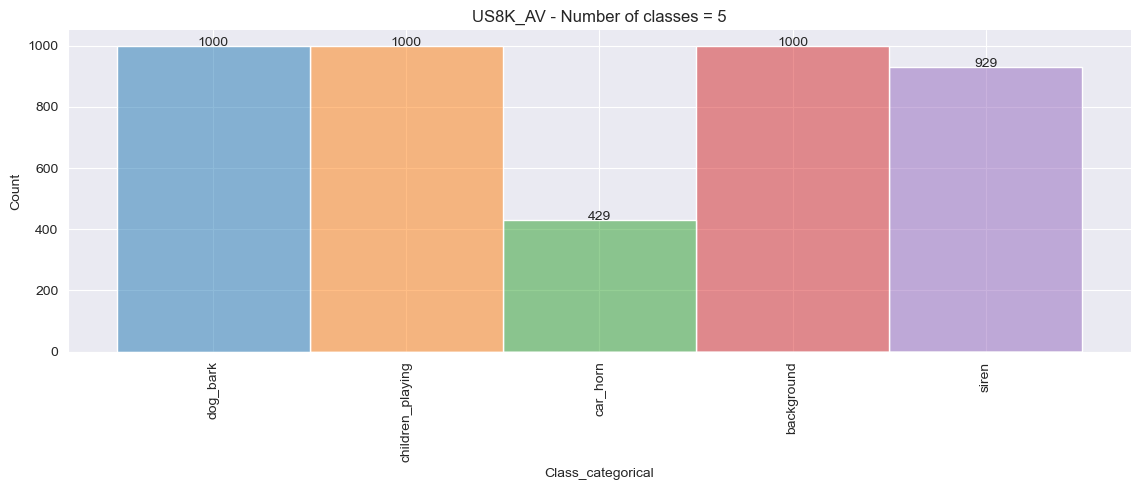

In [11]:
# Analysis of the class balancing

sns.set_style("darkgrid")
gTitle = f'{nom_dataset} - Number of classes = ' + str(len(pd.Series(DB['Class_categorical']).unique()))
g = sns.displot(DB,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()

In [12]:
# Read the pkl file with the augmented features extracted

opc = 0
while str(opc) not in '123':
    print()
    print("1-) Features original")
    print("2-) Features augmented")
    print("3-) Features augmented and windowed (US8K only windowed)")

    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0

if opc == 1:
    DB_from_pkl   = pd.read_pickle(os.path.join(path_models, pkl_features))
    model_surname = '_original'

if opc == 2:
    DB_from_pkl   = pd.read_pickle(os.path.join(path_models, pkl_aug_features))
    model_surname = '_augmented'

if opc == 3:
    DB_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_aug_wind_features))
    model_surname = '_windowed'


1-) Features original
2-) Features augmented
3-) Features augmented and windowed (US8K only windowed)

Select the dataset: 2


In [13]:
DB_from_pkl.dtypes

Audio                  object
Class_categorical      object
Class_OHEV             object
Fold                   object
RMSE                  float64
                       ...   
TONNETZ_6             float64
TONNETZ_std_6         float64
TONNETZ_median_6      float64
TONNETZ_skew_6        float64
TONNETZ_kurtosis_6    float64
Length: 379, dtype: object

## Input split

In [14]:
# Separate 1 fold for validation and create a DB for the training / testing according to the datasets specification

DB_from_pkl_VAL = DB_from_pkl[DB_from_pkl['Fold'] == fold].copy()
DB_from_pkl_TRN = DB_from_pkl[DB_from_pkl['Fold'] != fold].copy()

In [15]:
print(len(DB_from_pkl_VAL))
print(len(DB_from_pkl_TRN))
print('Total: ', len(DB_from_pkl_VAL) + len(DB_from_pkl_TRN),'\n')

2580
23568
Total:  26148 



In [16]:
DB_from_pkl_VAL

,Audio,Class_categorical,Class_OHEV,Fold,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
198,"[6.402111e-05, 8.269498e-05, 5.2123058e-05, 7.1509836e-05, 3.3138364e-05, -6.1828905e-07, -8.950657e-05, -9.0291964e...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0.058633,0.040959,1271.206686,1928.231999,2472.957686,0.000278,...,-0.015292,0.035536,-0.020622,0.525709,1.746464,0.008707,0.037425,0.005560,1.162952,4.169823
199,"[-0.00012205808889120817, -6.719511293340474e-05, 2.905506335082464e-06, 1.9621737010311335e-05, -7.216424273792654e...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0.058588,0.052424,1345.458782,1942.451136,2588.838681,0.000286,...,-0.009075,0.039741,-0.018807,0.473680,0.313614,0.009733,0.035568,0.014633,-0.347878,0.356991
200,"[0.00012639583, 0.00014222636, 0.000105404404, 0.0001227224, 7.496913e-05, 4.0885887e-05, -5.7702182e-05, -6.593399e...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0.044850,0.045481,1334.401546,1955.784549,2693.206258,0.000890,...,-0.010955,0.044358,-0.009521,-0.128276,2.008432,0.005650,0.036304,0.004743,1.170191,4.859253
201,"[7.2012896e-05, 9.261185e-05, 6.220843e-05, 7.991052e-05, 4.3673655e-05, 1.0300708e-05, -7.6714656e-05, -8.089916e-0...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0.038950,0.043522,1237.423762,1869.291497,2335.605723,0.000145,...,-0.007646,0.036505,-0.018069,1.318428,1.869864,0.015626,0.040413,0.017422,0.084885,1.045394
202,"[-0.0004916204, -0.0004845793, -0.0004051199, -0.0004091697, -0.00038973408, -0.00031669112, -0.0003181837, -0.00019...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0.042435,0.050347,1285.435994,1815.208874,2359.005967,0.000027,...,0.014344,0.042449,0.016176,0.016887,3.785608,0.005422,0.044810,0.015639,-0.895844,0.774320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25999,"[0.19635623693466187, 0.18581242859363556, 0.17708247900009155, 0.164332777261734, 0.13725370168685913, 0.0964783430...",background,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",1,0.180010,0.089753,1221.480172,946.719249,2319.922581,0.070931,...,-0.053421,0.034766,-0.048251,-0.498406,-0.114032,0.050565,0.052032,0.041333,0.437309,-0.452519
26000,"[0.14415377, 0.14501688, 0.07689834, 0.025425414, -0.006366585, -0.022379085, -0.037201084, -0.06901321, -0.11600359...",background,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",1,0.133661,0.071458,1060.912989,866.323749,2066.129510,0.047855,...,-0.049034,0.036891,-0.051231,0.213951,-0.067818,0.043112,0.059774,0.042092,-0.053763,-0.564077
26001,"[0.1422672, 0.1433061, 0.0776205, 0.026498599, -0.0061451453, -0.023355447, -0.039021745, -0.070829675, -0.117393695...",background,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",1,0.125073,0.071831,1067.211768,880.291170,2080.256785,0.071220,...,-0.051139,0.036488,-0.053074,-0.092261,-0.886421,0.046344,0.060513,0.052972,-0.263813,-0.377502
26002,"[0.12572995, 0.13615799, 0.04033979, 0.0026515108, -0.0272303, -0.04199472, -0.0976441, -0.15186153, -0.18760645, -0...",background,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",1,0.123771,0.091763,1354.786205,1098.932536,2643.854148,0.059133,...,0.062839,0.049899,0.059482,0.152563,-0.376412,0.023421,0.053478,0.015523,0.209092,-0.480503


In [17]:
DB_from_pkl_TRN

,Audio,Class_categorical,Class_OHEV,Fold,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
0,"[-0.0034710653, -0.0050192624, -0.004654482, -0.0049833283, -0.0038681468, -0.0023575649, -0.00025486574, 0.00135406...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.121009,0.133490,2094.968187,1745.096817,2886.196035,0.000025,...,-0.023313,0.029888,-0.018669,-0.298720,-0.579663,-0.046785,0.024244,-0.049756,0.759231,-0.024962
1,"[-0.043454281985759735, -0.15738531947135925, -0.18409189581871033, -0.027355656027793884, 0.03697749972343445, 0.27...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.060639,0.250508,2665.521570,2068.181629,4066.476952,0.004068,...,-0.024523,0.021035,-0.028479,0.477347,0.095514,0.016315,0.031251,0.011006,-0.009143,-1.237222
2,"[-0.0035122973, -0.0050051752, -0.0045919046, -0.0048774146, -0.0037652655, -0.0022669514, -0.00015891435, 0.0014704...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.100775,0.133033,2106.590578,1777.133904,2892.543974,0.000016,...,-0.049970,0.031053,-0.057323,0.214288,-0.733329,-0.025334,0.031054,-0.028243,0.298586,-0.490271
3,"[-0.003488453, -0.004396054, -0.0037757251, -0.0042094756, -0.0030081559, -0.0015460963, 0.00081547524, 0.0026281716...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.113409,0.135708,2104.516302,1756.504203,2906.857952,0.000055,...,-0.017338,0.024289,-0.014603,-0.185764,-0.548766,0.000113,0.025748,-0.000898,-0.077263,-0.095841
4,"[-0.003237898, -0.0050192326, -0.0046117576, -0.004234772, -0.0019701908, 0.00027243508, 0.0026218973, 0.004221949, ...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.099378,0.171356,2391.238889,1600.176672,3377.165513,0.000008,...,-0.000741,0.026688,-0.001909,-0.054720,-0.604616,0.028016,0.027486,0.031821,-0.303592,0.219901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26143,"[-0.0003149189980546246, 0.0006682084909744623, 0.0009832569855925959, 0.00016151153927448773, 0.0008422290776341366...",car_horn,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",7,0.011347,0.183402,2501.491456,2235.239365,4419.534355,0.030417,...,0.028042,0.025818,0.028490,0.194797,-0.528515,-0.037509,0.045186,-0.024772,-0.485722,-0.826845
26144,"[0.013614702, 0.025402728, 0.023213908, 0.021975169, 0.016956959, 0.015239683, 0.010343045, 0.008701391, 0.006488053...",car_horn,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",7,0.007441,0.169775,2451.759370,2226.848215,4341.056409,0.014329,...,0.024047,0.031035,0.029566,-0.528228,-0.297265,-0.014086,0.035080,-0.011528,-0.423708,-0.874833
26145,"[0.013724111, 0.025209483, 0.02299475, 0.021716274, 0.016808376, 0.015125214, 0.010314408, 0.008703265, 0.006482009,...",car_horn,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",7,0.007879,0.172665,2474.068169,2231.898528,4340.309593,0.014456,...,0.023623,0.021582,0.022543,0.224521,0.105888,-0.043505,0.040739,-0.032216,-0.795570,-0.144473
26146,"[0.013087595, 0.025674945, 0.022199064, 0.01882483, 0.014130215, 0.0101510435, 0.0071426327, 0.007999478, 0.01828633...",car_horn,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",7,0.008052,0.215036,2811.051384,2258.299641,4993.275972,0.010402,...,-0.032974,0.035019,-0.032837,0.005823,-0.685219,-0.000129,0.034881,-0.006539,0.611093,-0.761275


In [18]:
for i in DB_from_pkl_TRN.columns:
    print(i)

Audio
Class_categorical
Class_OHEV
Fold
RMSE
ZCR
CENTROIDS
BANDWIDTH
ROLLOFF
MEL_1
MEL_2
MEL_3
MEL_4
MEL_5
MEL_6
MEL_7
MEL_8
MEL_9
MEL_10
MEL_11
MEL_12
MEL_13
MEL_14
MEL_15
MEL_16
MEL_17
MEL_18
MEL_19
MEL_20
MEL_21
MEL_22
MEL_23
MEL_24
MEL_25
MEL_26
MEL_27
MEL_28
MEL_29
MEL_30
MEL_31
MEL_32
MEL_33
MEL_34
MEL_35
MEL_36
MEL_37
MEL_38
MEL_39
MEL_40
MEL_41
MEL_42
MEL_43
MEL_44
MEL_45
MEL_46
MEL_47
MEL_48
MEL_49
MEL_50
MEL_51
MEL_52
MEL_53
MEL_54
MEL_55
MEL_56
MEL_57
MEL_58
MEL_59
MEL_60
MEL_61
MEL_62
MEL_63
MEL_64
MEL_65
MEL_66
MEL_67
MEL_68
MEL_69
MEL_70
MEL_71
MEL_72
MEL_73
MEL_74
MEL_75
MEL_76
MEL_77
MEL_78
MEL_79
MEL_80
MEL_81
MEL_82
MEL_83
MEL_84
MEL_85
MEL_86
MEL_87
MEL_88
MEL_89
MEL_90
MEL_91
MEL_92
MEL_93
MEL_94
MEL_95
MEL_96
MEL_97
MEL_98
MEL_99
MEL_100
MEL_101
MEL_102
MEL_103
MEL_104
MEL_105
MEL_106
MEL_107
MEL_108
MEL_109
MEL_110
MEL_111
MEL_112
MEL_113
MEL_114
MEL_115
MEL_116
MEL_117
MEL_118
MEL_119
MEL_120
MEL_121
MEL_122
MEL_123
MEL_124
MEL_125
MEL_126
MEL_127
MEL_128
MFCC_1


In [19]:
# Separating data and labels

X      = DB_from_pkl_TRN.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
y      = np.array(DB_from_pkl_TRN.Class_categorical.to_list())
y_OHEV = np.array(DB_from_pkl_TRN.Class_OHEV.to_list())

In [20]:
# For the augmented dataset (only validation set)

X_val      = DB_from_pkl_VAL.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
y_val      = np.array(DB_from_pkl_VAL.Class_categorical.to_list())
y_OHEV_val = np.array(DB_from_pkl_VAL.Class_OHEV.to_list())

In [21]:
X

,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,MEL_2,MEL_3,MEL_4,MEL_5,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
0,0.121009,0.133490,2094.968187,1745.096817,2886.196035,0.000025,0.000224,0.000292,0.000570,0.000518,...,-0.023313,0.029888,-0.018669,-0.298720,-0.579663,-0.046785,0.024244,-0.049756,0.759231,-0.024962
1,0.060639,0.250508,2665.521570,2068.181629,4066.476952,0.004068,0.003986,0.003182,0.003502,0.004180,...,-0.024523,0.021035,-0.028479,0.477347,0.095514,0.016315,0.031251,0.011006,-0.009143,-1.237222
2,0.100775,0.133033,2106.590578,1777.133904,2892.543974,0.000016,0.000186,0.000224,0.000397,0.000263,...,-0.049970,0.031053,-0.057323,0.214288,-0.733329,-0.025334,0.031054,-0.028243,0.298586,-0.490271
3,0.113409,0.135708,2104.516302,1756.504203,2906.857952,0.000055,0.000225,0.000297,0.000532,0.000498,...,-0.017338,0.024289,-0.014603,-0.185764,-0.548766,0.000113,0.025748,-0.000898,-0.077263,-0.095841
4,0.099378,0.171356,2391.238889,1600.176672,3377.165513,0.000008,0.000054,0.000232,0.000081,0.000304,...,-0.000741,0.026688,-0.001909,-0.054720,-0.604616,0.028016,0.027486,0.031821,-0.303592,0.219901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26143,0.011347,0.183402,2501.491456,2235.239365,4419.534355,0.030417,0.047205,0.103456,0.111890,0.124702,...,0.028042,0.025818,0.028490,0.194797,-0.528515,-0.037509,0.045186,-0.024772,-0.485722,-0.826845
26144,0.007441,0.169775,2451.759370,2226.848215,4341.056409,0.014329,0.022963,0.065699,0.064291,0.061877,...,0.024047,0.031035,0.029566,-0.528228,-0.297265,-0.014086,0.035080,-0.011528,-0.423708,-0.874833
26145,0.007879,0.172665,2474.068169,2231.898528,4340.309593,0.014456,0.022792,0.053709,0.061791,0.081740,...,0.023623,0.021582,0.022543,0.224521,0.105888,-0.043505,0.040739,-0.032216,-0.795570,-0.144473
26146,0.008052,0.215036,2811.051384,2258.299641,4993.275972,0.010402,0.021294,0.018830,0.055645,0.037642,...,-0.032974,0.035019,-0.032837,0.005823,-0.685219,-0.000129,0.034881,-0.006539,0.611093,-0.761275


In [22]:
X.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,MEL_2,MEL_3,MEL_4,MEL_5,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,23568.000000,23568.000000,23568.000000,23568.000000,23568.000000,2.356800e+04,2.356800e+04,2.356800e+04,2.356800e+04,2.356800e+04,...,23568.000000,23568.000000,23568.000000,23568.000000,23568.000000,23568.000000,23568.000000,23568.000000,23568.000000,23568.000000
mean,0.050250,0.116839,1934.251675,1889.262937,3599.650386,5.967800e+00,7.292076e+00,5.209773e+00,3.050860e+00,2.753831e+00,...,0.000227,0.035299,0.000335,-0.002363,0.231770,0.000489,0.035178,-0.001267,0.185920,0.174003
std,0.054129,0.076975,841.843880,535.917835,1679.010974,4.340014e+01,5.096004e+01,2.818132e+01,1.505756e+01,1.680023e+01,...,0.036186,0.022195,0.037291,0.610635,2.127801,0.032250,0.022018,0.033819,0.574952,1.835314
min,0.000114,0.000045,234.859256,459.089402,174.443839,5.318781e-09,3.432321e-09,5.866951e-09,6.608183e-09,4.823168e-09,...,-0.303433,0.003650,-0.308068,-5.591275,-1.743214,-0.213683,0.005217,-0.236607,-6.860189,-1.817128
25%,0.015055,0.069059,1366.636593,1504.225587,2381.955009,4.432022e-03,1.174164e-02,1.618576e-02,1.602973e-02,1.605037e-02,...,-0.011268,0.022639,-0.010822,-0.318699,-0.573787,-0.012434,0.022640,-0.013972,-0.135010,-0.587260
50%,0.032179,0.099398,1788.215965,1850.277482,3293.802144,7.002851e-02,1.304144e-01,1.677645e-01,1.550285e-01,1.513367e-01,...,0.001406,0.029621,0.001585,-0.002858,-0.170975,0.000073,0.029439,-0.001324,0.160128,-0.177746
75%,0.066965,0.138480,2286.780734,2225.412529,4434.081714,8.127327e-01,1.526101e+00,1.502245e+00,1.101650e+00,9.817800e-01,...,0.014440,0.040749,0.014308,0.295235,0.450707,0.012804,0.040615,0.011102,0.482515,0.438269
max,0.680869,0.638689,6620.608782,4315.795062,10042.189758,1.649878e+03,2.361642e+03,1.141907e+03,4.306573e+02,7.601108e+02,...,0.229385,0.252600,0.252222,7.771866,75.028109,0.305544,0.244369,0.320718,7.197460,62.777422


In [23]:
y

array(['dog_bark', 'dog_bark', 'dog_bark', ..., 'car_horn', 'car_horn',
       'car_horn'], dtype='<U16')

In [24]:
X_norm = X.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [25]:
X_standard = X.apply(lambda x: (x - x.mean()) / x.std())

In [26]:
X_norm.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,MEL_2,MEL_3,MEL_4,MEL_5,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,23568.000000,23568.000000,23568.000000,23568.000000,23568.000000,23568.000000,23568.000000,23568.000000,23568.000000,23568.000000,...,23568.000000,23568.000000,23568.000000,23568.000000,23568.000000,23568.000000,23568.000000,23568.000000,23568.000000,23568.000000
mean,0.073648,0.182879,0.266123,0.370828,0.347111,0.003617,0.003088,0.004562,0.007084,0.003623,...,0.569913,0.127131,0.550434,0.418233,0.025726,0.412483,0.125280,0.422267,0.501230,0.030825
std,0.079514,0.120529,0.131832,0.138957,0.170151,0.026305,0.021578,0.024679,0.034964,0.022102,...,0.067914,0.089153,0.066556,0.045695,0.027716,0.062112,0.092067,0.060681,0.040900,0.028413
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.021948,0.108064,0.177235,0.270992,0.223710,0.000003,0.000005,0.000014,0.000037,0.000021,...,0.548339,0.076274,0.530521,0.394561,0.015233,0.387594,0.072854,0.399470,0.478400,0.019040
50%,0.047103,0.155568,0.243254,0.360719,0.316117,0.000042,0.000055,0.000147,0.000360,0.000199,...,0.572127,0.104320,0.552665,0.418196,0.020480,0.411682,0.101282,0.422165,0.499395,0.025380
75%,0.098201,0.216764,0.321328,0.457988,0.431673,0.000493,0.000646,0.001316,0.002558,0.001292,...,0.596590,0.149023,0.575373,0.440503,0.028577,0.436202,0.148016,0.444460,0.522328,0.034916
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
X_standard.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,MEL_2,MEL_3,MEL_4,MEL_5,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,2.356800e+04,2.356800e+04,2.356800e+04,2.356800e+04,2.356800e+04,2.356800e+04,2.356800e+04,2.356800e+04,2.356800e+04,2.356800e+04,...,23568.000000,2.356800e+04,2.356800e+04,2.356800e+04,2.356800e+04,2.356800e+04,2.356800e+04,23568.000000,2.356800e+04,2.356800e+04
mean,4.100213e-17,8.682803e-17,-9.647559e-17,3.714310e-16,2.894268e-17,-2.894268e-17,-2.411890e-18,-6.632697e-18,3.617835e-17,-1.205945e-18,...,0.000000,-4.823780e-18,-2.411890e-18,-6.632697e-18,-6.029725e-18,7.235669e-18,-1.350658e-16,0.000000,3.316348e-17,7.235669e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
min,-9.262373e-01,-1.517303e+00,-2.018655e+00,-2.668643e+00,-2.040014e+00,-1.375065e-01,-1.430940e-01,-1.848662e-01,-2.026132e-01,-1.639163e-01,...,-8.391688,-1.425995e+00,-8.270241e+00,-9.152623e+00,-9.281805e-01,-6.641002e+00,-1.360745e+00,-6.958775,-1.225513e+01,-1.084900e+00
25%,-6.502077e-01,-6.207230e-01,-6.742522e-01,-7.184634e-01,-7.252456e-01,-1.374043e-01,-1.428636e-01,-1.842918e-01,-2.015486e-01,-1.629609e-01,...,-0.317662,-5.704490e-01,-2.991934e-01,-5.180444e-01,-3.785866e-01,-4.007051e-01,-5.694299e-01,-0.375686,-5.581863e-01,-4.147866e-01
50%,-3.338480e-01,-2.265902e-01,-1.734712e-01,-7.274521e-02,-1.821598e-01,-1.358929e-01,-1.405348e-01,-1.789131e-01,-1.923175e-01,-1.549083e-01,...,0.032601,-2.558679e-01,3.352081e-02,-8.093683e-04,-1.892775e-01,-1.288931e-02,-2.606557e-01,-0.001684,-4.485983e-02,-1.916564e-01
75%,3.087896e-01,2.811367e-01,4.187582e-01,6.272409e-01,4.969779e-01,-1.187800e-01,-1.131470e-01,-1.315597e-01,-1.294506e-01,-1.054778e-01,...,0.392804,2.455527e-01,3.747103e-01,4.873580e-01,1.028935e-01,3.818756e-01,2.469548e-01,0.365723,5.158598e-01,1.439895e-01
max,1.165024e+01,6.779470e+00,5.566777e+00,4.527806e+00,3.837104e+00,3.787800e+01,4.619992e+01,4.033512e+01,2.839813e+01,4.508016e+01,...,6.332817,9.790728e+00,6.754700e+00,1.273138e+01,3.515193e+01,9.459070e+00,9.500924e+00,9.520774,1.219500e+01,3.411047e+01


In [28]:
X_norm = X_norm.values

In [29]:
X_standard = X_standard.values

In [30]:
X_norm.shape

(23568, 375)

In [31]:
X_standard.shape

(23568, 375)

In [32]:
y.shape

(23568,)

In [33]:
len(X_norm)

23568

In [34]:
len(X_standard)

23568

In [35]:
X_val

,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,MEL_2,MEL_3,MEL_4,MEL_5,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
198,0.058633,0.040959,1271.206686,1928.231999,2472.957686,0.000278,0.003713,0.009854,0.010550,0.008248,...,-0.015292,0.035536,-0.020622,0.525709,1.746464,0.008707,0.037425,0.005560,1.162952,4.169823
199,0.058588,0.052424,1345.458782,1942.451136,2588.838681,0.000286,0.003663,0.009750,0.010391,0.008237,...,-0.009075,0.039741,-0.018807,0.473680,0.313614,0.009733,0.035568,0.014633,-0.347878,0.356991
200,0.044850,0.045481,1334.401546,1955.784549,2693.206258,0.000890,0.002748,0.005336,0.005500,0.004168,...,-0.010955,0.044358,-0.009521,-0.128276,2.008432,0.005650,0.036304,0.004743,1.170191,4.859253
201,0.038950,0.043522,1237.423762,1869.291497,2335.605723,0.000145,0.001687,0.004743,0.005376,0.003721,...,-0.007646,0.036505,-0.018069,1.318428,1.869864,0.015626,0.040413,0.017422,0.084885,1.045394
202,0.042435,0.050347,1285.435994,1815.208874,2359.005967,0.000027,0.000418,0.002549,0.004436,0.004310,...,0.014344,0.042449,0.016176,0.016887,3.785608,0.005422,0.044810,0.015639,-0.895844,0.774320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25999,0.180010,0.089753,1221.480172,946.719249,2319.922581,0.070931,0.224975,1.194816,2.253192,4.556930,...,-0.053421,0.034766,-0.048251,-0.498406,-0.114032,0.050565,0.052032,0.041333,0.437309,-0.452519
26000,0.133661,0.071458,1060.912989,866.323749,2066.129510,0.047855,0.087350,0.474609,0.589145,0.837957,...,-0.049034,0.036891,-0.051231,0.213951,-0.067818,0.043112,0.059774,0.042092,-0.053763,-0.564077
26001,0.125073,0.071831,1067.211768,880.291170,2080.256785,0.071220,0.230007,1.066069,1.066060,2.488744,...,-0.051139,0.036488,-0.053074,-0.092261,-0.886421,0.046344,0.060513,0.052972,-0.263813,-0.377502
26002,0.123771,0.091763,1354.786205,1098.932536,2643.854148,0.059133,0.003818,0.284392,0.626982,0.821801,...,0.062839,0.049899,0.059482,0.152563,-0.376412,0.023421,0.053478,0.015523,0.209092,-0.480503


In [36]:
X_val.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,MEL_2,MEL_3,MEL_4,MEL_5,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2.580000e+03,2.580000e+03,2.580000e+03,2.580000e+03,2.580000e+03,...,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000
mean,0.053311,0.120421,2019.540001,1936.655688,3733.361522,8.349373e+00,1.151275e+01,9.719290e+00,5.868661e+00,4.227190e+00,...,0.003177,0.043157,0.003063,-0.029438,0.235268,0.001880,0.042878,-0.002551,0.200672,0.182447
std,0.053362,0.083847,965.023003,534.455071,1811.137814,3.294616e+01,6.010275e+01,6.646942e+01,3.572042e+01,1.723379e+01,...,0.036158,0.041433,0.036969,0.599069,1.521954,0.033822,0.040022,0.038762,0.599193,1.410010
min,0.000272,0.006853,276.986545,622.740800,200.769114,2.464049e-08,4.586947e-08,3.637480e-08,1.133756e-07,4.633142e-07,...,-0.204996,0.003148,-0.218632,-3.061532,-1.566914,-0.167547,0.003624,-0.175614,-2.456656,-1.633450
25%,0.012448,0.065534,1331.530871,1586.608277,2320.389341,1.683615e-03,6.067159e-03,6.682783e-03,1.062822e-02,1.215526e-02,...,-0.009853,0.022587,-0.009346,-0.314649,-0.642334,-0.012678,0.022499,-0.016937,-0.144449,-0.631418
50%,0.033779,0.106070,1879.705622,1888.155875,3483.213427,8.919546e-02,1.018020e-01,1.030296e-01,1.066576e-01,1.165047e-01,...,0.003333,0.030240,0.003288,-0.013162,-0.155493,0.000646,0.030300,-0.001239,0.203207,-0.193226
75%,0.079553,0.145710,2423.337990,2263.344416,4670.838037,1.052161e+00,1.345630e+00,8.154611e-01,6.344315e-01,6.284976e-01,...,0.017613,0.042696,0.017322,0.280815,0.558447,0.013741,0.043215,0.011756,0.548673,0.524254
max,0.285169,0.740940,6791.361802,3595.119271,9675.751897,3.690433e+02,1.003662e+03,1.224398e+03,9.036373e+02,4.495471e+02,...,0.162151,0.204976,0.228548,3.899806,19.958362,0.186308,0.202533,0.199802,2.854358,11.779031


In [37]:
y_val

array(['dog_bark', 'dog_bark', 'dog_bark', ..., 'background',
       'background', 'background'], dtype='<U16')

In [38]:
X_val_norm = X_val.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [39]:
X_val_standard = X_val.apply(lambda x: (x - x.mean()) / x.std())

In [40]:
X_val_norm.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,MEL_2,MEL_3,MEL_4,MEL_5,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,...,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000
mean,0.186169,0.154707,0.267494,0.442042,0.372834,0.022624,0.011471,0.007938,0.006494,0.009403,...,0.567002,0.198233,0.495763,0.435562,0.083724,0.478805,0.197344,0.460988,0.500343,0.135389
std,0.187302,0.114220,0.148137,0.179807,0.191149,0.089275,0.059883,0.054287,0.039530,0.038336,...,0.098483,0.205291,0.082672,0.086057,0.070705,0.095581,0.201206,0.103251,0.112821,0.105127
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.042738,0.079938,0.161880,0.324275,0.223707,0.000005,0.000006,0.000005,0.000012,0.000027,...,0.531513,0.096313,0.468013,0.394591,0.042953,0.437663,0.094890,0.422668,0.435361,0.074709
50%,0.117612,0.135157,0.246028,0.425725,0.346433,0.000242,0.000101,0.000084,0.000118,0.000259,...,0.567428,0.134229,0.496267,0.437900,0.065570,0.475316,0.134112,0.464485,0.500820,0.107379
75%,0.278279,0.189156,0.329479,0.551950,0.471776,0.002851,0.001341,0.000666,0.000702,0.001398,...,0.606322,0.195946,0.527649,0.480130,0.098738,0.512323,0.199037,0.499100,0.565867,0.160873
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [41]:
X_val_standard.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_1,MEL_2,MEL_3,MEL_4,MEL_5,...,TONNETZ_5,TONNETZ_std_5,TONNETZ_median_5,TONNETZ_skew_5,TONNETZ_kurtosis_5,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,2.580000e+03,2.580000e+03,2.580000e+03,2.580000e+03,2.580000e+03,2.580000e+03,2.580000e+03,2.580000e+03,2.580000e+03,2.580000e+03,...,2.580000e+03,2.580000e+03,2580.000000,2580.000000,2.580000e+03,2.580000e+03,2.580000e+03,2580.000000,2.580000e+03,2580.000000
mean,-3.304850e-17,8.812933e-17,1.046536e-16,-3.800577e-16,5.508083e-17,4.406467e-17,1.101617e-17,-1.101617e-17,-2.203233e-17,3.304850e-17,...,-1.101617e-17,6.609700e-17,0.000000,0.000000,-2.203233e-17,-5.508083e-18,-1.321940e-16,0.000000,1.101617e-17,0.000000
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000
min,-9.939514e-01,-1.354462e+00,-1.805712e+00,-2.458420e+00,-1.950482e+00,-2.534248e-01,-1.915511e-01,-1.462220e-01,-1.642943e-01,-2.452849e-01,...,-5.757340e+00,-9.656213e-01,-5.996771,-5.061346,-1.184124e+00,-5.009411e+00,-9.808059e-01,-4.464737,-4.434842e+00,-1.287861
25%,-7.657752e-01,-6.546043e-01,-7.129458e-01,-6.549613e-01,-7.801572e-01,-2.533737e-01,-1.914502e-01,-1.461214e-01,-1.639968e-01,-2.445796e-01,...,-3.603556e-01,-4.964651e-01,-0.335663,-0.476091,-5.766284e-01,-4.304411e-01,-5.091990e-01,-0.371135,-5.759754e-01,-0.577205
50%,-3.660237e-01,-1.711572e-01,-1.449026e-01,-9.074629e-02,-1.381165e-01,-2.507175e-01,-1.898573e-01,-1.446719e-01,-1.613084e-01,-2.385247e-01,...,4.332523e-03,-3.117708e-01,0.006095,0.027169,-2.567495e-01,-3.650775e-02,-3.142677e-01,0.033866,4.231807e-03,-0.266433
75%,4.917746e-01,3.016025e-01,4.184335e-01,6.112557e-01,5.176174e-01,-2.214890e-01,-1.691623e-01,-1.339538e-01,-1.465333e-01,-2.088160e-01,...,3.992616e-01,-1.113880e-02,0.385703,0.517892,2.123449e-01,3.506763e-01,8.411538e-03,0.369119,5.807828e-01,0.242415
max,4.345021e+00,7.400571e+00,4.944775e+00,3.103093e+00,3.281026e+00,1.094798e+01,1.650755e+01,1.827424e+01,2.513321e+01,2.583992e+01,...,4.396670e+00,3.905525e+00,6.099280,6.558920,1.295906e+01,5.452905e+00,3.989218e+00,5.220412,4.428765e+00,8.224471


In [42]:
X_val_norm = X_val_norm.values

In [43]:
X_val_standard = X_val_standard.values

In [44]:
X_val_norm.shape

(2580, 375)

In [45]:
X_val_standard.shape

(2580, 375)

In [46]:
y_val.shape

(2580,)

In [47]:
len(y_val)

2580

In [48]:
Counter_val = Counter(y_val)
Counter_val

Counter({'dog_bark': 600,
         'background': 648,
         'children_playing': 600,
         'siren': 516,
         'car_horn': 216})

In [49]:
# Group by the class and get one random sample of each class
k = DB_from_pkl.groupby('Class_categorical')['Class_OHEV'].apply(lambda s: s.sample(1))
print(k)

# Convert the pandas series into a dataframe
temp_k_df = k.reset_index()

# Delete the index from the grouppby result
del temp_k_df['level_1']

# Set the "Class" as the dataframe index
temp_k_df.set_index("Class_categorical", inplace=True)

# Convert the dataframe to a dictionary (Class: Class_encoder)
encoder_dict = temp_k_df["Class_OHEV"].to_dict()
encoder_dict

Class_categorical       
background         25384    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
car_horn           8679     [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
children_playing   818      [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
dog_bark           20868    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
siren              16555    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Name: Class_OHEV, dtype: object


{'background': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 'car_horn': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 'children_playing': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 'dog_bark': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 'siren': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]}

In [50]:
nom_classes = list(encoder_dict.keys())
nom_classes

['background', 'car_horn', 'children_playing', 'dog_bark', 'siren']

## StratifiedKFold

It is used for performing stratified k-fold cross-validation. It divides your dataset into 'k' equal-sized folds while ensuring that each fold maintains the same class distribution as the original dataset. This technique is valuable when you have a limited amount of data, and you want to maximize the use of your data for training and testing by creating multiple train-test splits.

Key points about StratifiedKFold:

- It's typically used for model evaluation, especially when you have a small dataset.
- You specify the number of folds (n_splits), and it creates 'k' folds with each fold maintaining the class distribution.
- It's used in conjunction with cross-validation functions like cross_val_score or cross_validate to assess your model's performance.

## StratifiedShuffleSplit 

It is primarily used for creating random train-test splits while ensuring that the class distribution is maintained in both the training and testing sets. This is particularly useful when you have a relatively large dataset and want to create multiple random splits to evaluate your model's performance or perform hyperparameter tuning.

Key points about StratifiedShuffleSplit:

- It randomly shuffles the data and splits it into train and test sets, preserving the class distribution.
- You specify the number of splits (n_splits), the test set size or proportion (test_size), and can optionally set a random seed for reproducibility.
- It's commonly used for tasks like model evaluation, cross-validation, and hyperparameter tuning.

In [51]:
N_SPLITS  = 5
cmap_data = plt.cm.viridis
cmap_cv   = plt.cm.coolwarm
cmap_cm   = plt.cm.Blues

sss = StratifiedShuffleSplit(n_splits = N_SPLITS, test_size=0.1, random_state=100)
skf = StratifiedKFold(n_splits = N_SPLITS, random_state=None, shuffle=False)
kfd = KFold(N_SPLITS)

In [52]:
sss

StratifiedShuffleSplit(n_splits=5, random_state=100, test_size=0.1,
            train_size=None)

In [53]:
skf

StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

In [54]:
kfd

KFold(n_splits=5, random_state=None, shuffle=False)

In [55]:
# Creates the train / test split
for idx_trn, idx_tst in sss.split(X_norm, y):
    X_train      = X_norm[idx_trn]
    X_test       = X_norm[idx_tst]
    y_train      = y[idx_trn]
    y_test       = y[idx_tst]
    y_train_OHEV = y_OHEV[idx_trn]
    y_test_OHEV  = y_OHEV[idx_tst]

In [56]:
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(y_test))
print(np.shape(y_train_OHEV))
print(np.shape(y_test_OHEV))

(21211, 375)
(2357, 375)
(21211,)
(2357,)
(21211, 10)
(2357, 10)


In [57]:
X_train

array([[0.11457499, 0.13363444, 0.25784643, ..., 0.55076753, 0.44655239,
        0.02131345],
       [0.02461609, 0.30192598, 0.42549422, ..., 0.45180248, 0.49858243,
        0.02519229],
       [0.02263165, 0.08653226, 0.07284402, ..., 0.45376057, 0.4566635 ,
        0.02753879],
       ...,
       [0.24773255, 0.15336274, 0.21911276, ..., 0.38680596, 0.51269843,
        0.01846633],
       [0.07973903, 0.16777005, 0.29998211, ..., 0.33598459, 0.52715944,
        0.01500405],
       [0.05014851, 0.15753467, 0.21222861, ..., 0.42885797, 0.48932078,
        0.02550759]])

In [58]:
y_train

array(['background', 'dog_bark', 'siren', ..., 'siren', 'siren', 'siren'],
      dtype='<U16')

In [59]:
y_train_OHEV

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [60]:
for i in y_test:
    print(i)

siren
dog_bark
dog_bark
siren
car_horn
dog_bark
background
background
background
dog_bark
children_playing
siren
siren
car_horn
children_playing
dog_bark
children_playing
dog_bark
dog_bark
background
children_playing
dog_bark
dog_bark
background
background
children_playing
car_horn
background
car_horn
dog_bark
siren
background
children_playing
dog_bark
dog_bark
dog_bark
car_horn
siren
children_playing
background
background
background
dog_bark
children_playing
dog_bark
children_playing
background
car_horn
background
children_playing
car_horn
children_playing
dog_bark
car_horn
background
background
car_horn
background
background
background
background
children_playing
background
children_playing
dog_bark
siren
siren
children_playing
car_horn
children_playing
siren
background
siren
dog_bark
dog_bark
dog_bark
children_playing
car_horn
background
children_playing
car_horn
background
siren
car_horn
children_playing
children_playing
background
background
background
siren
dog_bark
background
si

In [61]:
y_test[0]

'siren'

In [62]:
list_counter_test = Counter(y_test)
list_counter_test

Counter({'siren': 506,
         'dog_bark': 540,
         'car_horn': 236,
         'background': 535,
         'children_playing': 540})

In [63]:
list_counter_test_OHEV = Counter(map(tuple, y_test_OHEV))
list_counter_test_OHEV

Counter({(0, 0, 0, 0, 0, 0, 0, 0, 1, 0): 506,
         (0, 0, 0, 1, 0, 0, 0, 0, 0, 0): 540,
         (0, 1, 0, 0, 0, 0, 0, 0, 0, 0): 236,
         (0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 139,
         (0, 0, 0, 0, 0, 0, 0, 0, 0, 1): 138,
         (0, 0, 1, 0, 0, 0, 0, 0, 0, 0): 540,
         (0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 127,
         (0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 131})

In [64]:
list_counter_train = Counter(y_train)
list_counter_train

Counter({'background': 4817,
         'dog_bark': 4860,
         'siren': 4552,
         'car_horn': 2122,
         'children_playing': 4860})

In [65]:
list_counter_train_OHEV = Counter(map(tuple, y_train_OHEV))
list_counter_train_OHEV

Counter({(0, 0, 0, 0, 0, 1, 0, 0, 0, 0): 1229,
         (0, 0, 0, 1, 0, 0, 0, 0, 0, 0): 4860,
         (0, 0, 0, 0, 0, 0, 0, 0, 1, 0): 4552,
         (0, 1, 0, 0, 0, 0, 0, 0, 0, 0): 2122,
         (0, 0, 1, 0, 0, 0, 0, 0, 0, 0): 4860,
         (0, 0, 0, 0, 0, 0, 0, 1, 0, 0): 1139,
         (0, 0, 0, 0, 1, 0, 0, 0, 0, 0): 1219,
         (0, 0, 0, 0, 0, 0, 0, 0, 0, 1): 1230})

### Mutual information

Mutual information is calculated between two variables and measures the reduction in uncertainty for one variable given a known value of the other variable.

A quantity called mutual information measures the amount of information one can obtain from one random variable given another.

The mutual information between two random variables X and Y can be stated formally as follows:

\begin{aligned}
I(X ; Y) = H(X) – H(X | Y)
\end{aligned}

Where $I(X ; Y)$ is the mutual information for $X$ and $Y$, $H(X)$ is the entropy for $X$ and $H(X | Y)$ is the conditional entropy for $X$ given $Y$. The result has the units of bits. Since mutual information is a measure of dependence or “mutual dependence” between two random variables, the result measure is symmetrical, meaning that $I(X ; Y) = I(Y ; X)$.

\begin{aligned}
E=-\sum_i^C p_i \log _2 p_i
\end{aligned}

Where $p_i$ is the probability of randomly picking an element of class $i$ (i.e. the proportion of the dataset made up of class $i$).

In [66]:
# Compute the mutual information

mutual_info = mutual_info_classif(X_norm, y)
mutual_info

array([0.13591897, 0.11957574, 0.12697512, 0.13967345, 0.16963962,
       0.06205399, 0.10625324, 0.11425704, 0.11546862, 0.13217763,
       0.1374829 , 0.14842259, 0.13441003, 0.13076722, 0.11808215,
       0.12509992, 0.12027081, 0.12644821, 0.11978744, 0.13401008,
       0.15040692, 0.13414633, 0.13448637, 0.13710775, 0.13636451,
       0.11761156, 0.10613641, 0.11111843, 0.10956807, 0.09836224,
       0.09338733, 0.10174316, 0.09948877, 0.10676787, 0.10184065,
       0.10679026, 0.12014326, 0.11659488, 0.10380508, 0.09895721,
       0.10079709, 0.1012381 , 0.09918544, 0.10012269, 0.09400317,
       0.09329991, 0.08944594, 0.11224314, 0.10467938, 0.09302366,
       0.09882597, 0.10741449, 0.0976662 , 0.0991639 , 0.08696382,
       0.10043957, 0.10232339, 0.09805606, 0.0931801 , 0.08216154,
       0.08399827, 0.08877901, 0.08083757, 0.07264241, 0.07370902,
       0.07426291, 0.08305639, 0.07727645, 0.08110495, 0.08668175,
       0.08876561, 0.0751548 , 0.06528225, 0.07072569, 0.07894

In [67]:
mutual_info       = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)

MFCC_delta1_std_4       0.310143
MFCC_delta1_std_3       0.296630
MFCC_std_4              0.270821
MFCC_std_3              0.251347
MFCC_delta2_std_3       0.246226
                          ...   
TONNETZ_skew_1          0.015809
CONSTRAST_skew_1        0.015620
MFCC_delta2_mean_6      0.015274
CONSTRAST_kurtosis_2    0.007933
CONSTRAST_skew_2        0.005526
Length: 375, dtype: float64

In [68]:
threshold = np.mean(mutual_info.sort_values(ascending=False))
threshold

0.1010704825453046

In [69]:
count_mutual = sum(1 for element in mutual_info if element > threshold)
count_mutual

170

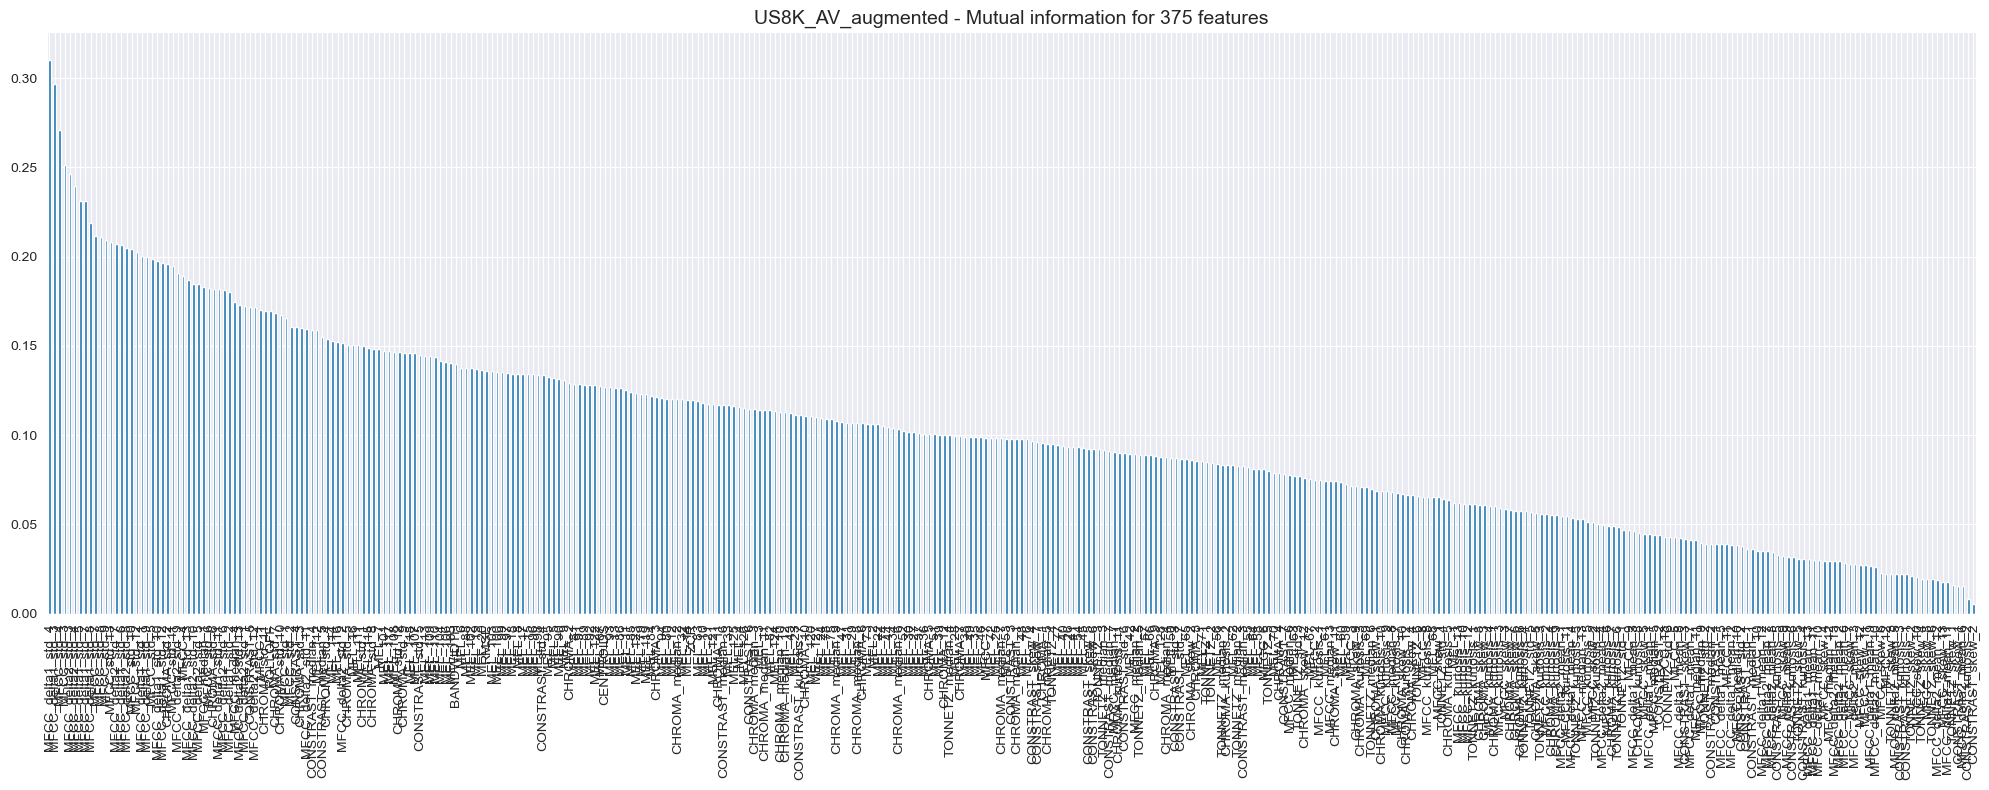

In [70]:
#Plot the sorted features based on their mutual information calculation

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))
plt.title(nom_dataset + model_surname + ' - Mutual information for ' + str(len(mutual_info)) + ' features', fontsize = 14)
plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))
plt.show()

### Backup for experiments using *n* relevant features

https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/

In [71]:
chi2_selector = SelectKBest(chi2, k=count_mutual).fit(X_norm, y)
f = chi2_selector.get_support(1)
f

array([  0,   1,   2,   3,   4,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  17,  22,  26,  27,  30,  31,  33,  36,  37,  38,  39,  40,
        41,  47,  48,  49,  51,  52,  53,  54,  55,  56,  57,  64,  70,
        77,  79,  83,  84,  88,  92,  94, 105, 106, 107, 110, 114, 115,
       118, 131, 132, 133, 134, 135, 137, 139, 141, 143, 146, 148, 150,
       152, 157, 159, 160, 161, 162, 166, 168, 170, 175, 177, 178, 179,
       180, 184, 186, 187, 188, 189, 193, 195, 196, 197, 202, 204, 206,
       211, 213, 215, 220, 222, 224, 229, 231, 233, 238, 240, 242, 247,
       249, 260, 261, 262, 265, 266, 267, 270, 271, 272, 275, 276, 277,
       281, 283, 284, 285, 286, 287, 289, 290, 291, 292, 294, 295, 296,
       297, 299, 300, 301, 302, 305, 306, 307, 309, 310, 311, 312, 314,
       315, 316, 317, 320, 321, 322, 325, 326, 327, 330, 331, 332, 334,
       335, 336, 337, 339, 340, 341, 342, 344, 346, 351, 356, 361, 366,
       371], dtype=int64)

In [72]:
# Stores the indexes for future use
f.tofile(os.path.join(path_models, '_mutual_idx_' + nom_dataset + model_surname + '.csv'), sep=',')

In [73]:
X_new = X[X.columns[f]] # final features
X_new

,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_3,MEL_4,MEL_5,MEL_6,MEL_7,...,CHROMA_12,CHROMA_std_12,CHROMA_median_12,CHROMA_kurtosis_12,TONNETZ_std_1,TONNETZ_std_2,TONNETZ_std_3,TONNETZ_std_4,TONNETZ_std_5,TONNETZ_std_6
0,0.121009,0.133490,2094.968187,1745.096817,2886.196035,0.000292,0.000570,0.000518,0.001145,0.005473,...,0.401244,0.238408,0.379407,0.069223,0.058841,0.050111,0.081682,0.116794,0.029888,0.024244
1,0.060639,0.250508,2665.521570,2068.181629,4066.476952,0.003182,0.003502,0.004180,0.003750,0.002499,...,0.458759,0.199937,0.393991,-0.603848,0.035547,0.044366,0.113032,0.067097,0.021035,0.031251
2,0.100775,0.133033,2106.590578,1777.133904,2892.543974,0.000224,0.000397,0.000263,0.000550,0.003744,...,0.217687,0.115980,0.233635,-1.041208,0.060656,0.053563,0.060675,0.144223,0.031053,0.031054
3,0.113409,0.135708,2104.516302,1756.504203,2906.857952,0.000297,0.000532,0.000498,0.001074,0.004973,...,0.416550,0.285692,0.354732,0.007319,0.047779,0.059444,0.111944,0.101142,0.024289,0.025748
4,0.099378,0.171356,2391.238889,1600.176672,3377.165513,0.000232,0.000081,0.000304,0.000268,0.000165,...,0.213544,0.104228,0.211061,1.339091,0.044539,0.067701,0.092240,0.079328,0.026688,0.027486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26143,0.011347,0.183402,2501.491456,2235.239365,4419.534355,0.103456,0.111890,0.124702,0.035660,0.026256,...,0.415510,0.222810,0.370988,0.399685,0.087063,0.092265,0.102330,0.047998,0.025818,0.045186
26144,0.007441,0.169775,2451.759370,2226.848215,4341.056409,0.065699,0.064291,0.061877,0.021045,0.015002,...,0.342398,0.187000,0.307623,0.204621,0.071423,0.095397,0.071516,0.076597,0.031035,0.035080
26145,0.007879,0.172665,2474.068169,2231.898528,4340.309593,0.053709,0.061791,0.081740,0.020313,0.013740,...,0.446822,0.247369,0.386783,-0.126618,0.081328,0.085114,0.109683,0.056501,0.021582,0.040739
26146,0.008052,0.215036,2811.051384,2258.299641,4993.275972,0.018830,0.055645,0.037642,0.040224,0.031911,...,0.624156,0.322755,0.562176,-1.645544,0.069318,0.095412,0.079969,0.068401,0.035019,0.034881


In [74]:
def get_mutual_info (X: pd.DataFrame, X_norm: list, y: list):
    
    mutual_info = mutual_info_classif(X_norm, y)
    mutual_info = pd.Series(mutual_info)
    mutual_info.index = X.columns
    mutual_info.sort_values(ascending=False)
    
    threshold = np.mean(mutual_info.sort_values(ascending=False))
    print(f' Threshold: {threshold}')
    
    count_mutual = sum(1 for element in mutual_info if element > threshold)
    print(f' Count mutual: {count_mutual}')
    
    chi2_selector = SelectKBest(chi2, k=count_mutual).fit(X_norm, y)
    f = chi2_selector.get_support(1)
    
    X_mutual = X[X.columns[f]] # final features

    return X_mutual

In [75]:
X_test_mutual = get_mutual_info(X, X_norm, y)

 Threshold: 0.10107620181590903
 Count mutual: 170


In [76]:
mutual_info_k_best = mutual_info_classif(X_new, y)
mutual_info_k_best

array([0.13587668, 0.11914938, 0.12697512, 0.13967199, 0.16918477,
       0.11431153, 0.1154464 , 0.13210498, 0.13750601, 0.14842721,
       0.13441835, 0.13081427, 0.11807391, 0.12511675, 0.12642378,
       0.13448842, 0.10616085, 0.11113861, 0.0933723 , 0.10170227,
       0.10676092, 0.12013059, 0.11658068, 0.10378574, 0.09891396,
       0.10079451, 0.10123981, 0.11219112, 0.10470407, 0.09301339,
       0.10740238, 0.09763595, 0.09916116, 0.08696985, 0.10043893,
       0.1023389 , 0.09807456, 0.07369988, 0.08873277, 0.106411  ,
       0.10876612, 0.1229734 , 0.12043244, 0.12176489, 0.13751595,
       0.13157814, 0.14705835, 0.13739221, 0.13582053, 0.14123966,
       0.14359215, 0.1501834 , 0.15277496, 0.11178311, 0.08792386,
       0.16980994, 0.16541183, 0.18278754, 0.07500342, 0.2005123 ,
       0.17207821, 0.16060855, 0.05599866, 0.18024034, 0.15167338,
       0.25133045, 0.29662565, 0.24617599, 0.18919407, 0.27083081,
       0.17431489, 0.3101655 , 0.23959225, 0.1984397 , 0.23103

In [77]:
mutual_info_k_best       = pd.Series(mutual_info_k_best)
mutual_info_k_best.index = X_new.columns
mutual_info_k_best.sort_values(ascending=False)

MFCC_delta1_std_4    0.310166
MFCC_delta1_std_3    0.296626
MFCC_std_4           0.270831
MFCC_std_3           0.251330
MFCC_delta2_std_3    0.246176
                       ...   
TONNETZ_std_5        0.056782
MFCC_kurtosis_2      0.055999
TONNETZ_std_1        0.046863
TONNETZ_std_6        0.042885
TONNETZ_std_2        0.039203
Length: 170, dtype: float64

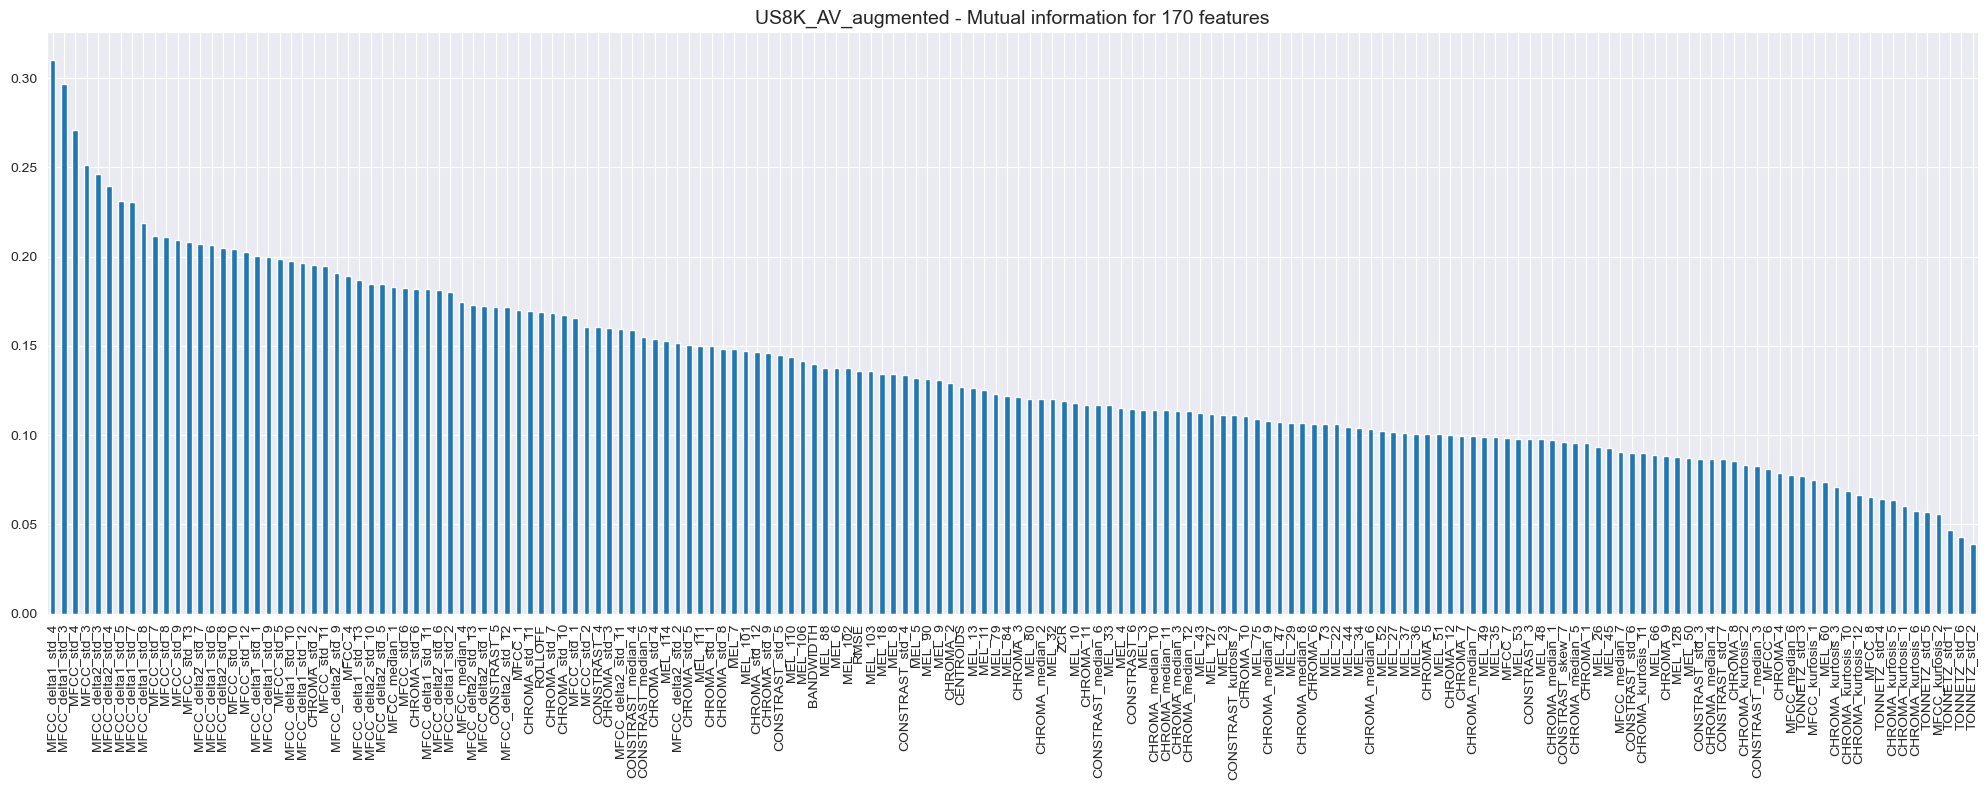

In [78]:
#Plot the sorted features based on their mutual information calculation

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

mutual_info_k_best.sort_values(ascending=False).plot.bar(figsize=(20, 8))
plt.title(nom_dataset + model_surname + ' - Mutual information for ' + str(len(mutual_info_k_best)) + ' features', fontsize = 14)
plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))
plt.show()

### Remark: by selection the features, re-nornamalize the dataframe

In [79]:
X_new.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,ROLLOFF,MEL_3,MEL_4,MEL_5,MEL_6,MEL_7,...,CHROMA_12,CHROMA_std_12,CHROMA_median_12,CHROMA_kurtosis_12,TONNETZ_std_1,TONNETZ_std_2,TONNETZ_std_3,TONNETZ_std_4,TONNETZ_std_5,TONNETZ_std_6
count,23568.000000,23568.000000,23568.000000,23568.000000,23568.000000,2.356800e+04,2.356800e+04,2.356800e+04,2.356800e+04,2.356800e+04,...,23568.000000,23568.000000,23568.000000,23568.000000,23568.000000,23568.000000,23568.000000,23568.000000,23568.000000,23568.000000
mean,0.050250,0.116839,1934.251675,1889.262937,3599.650386,5.209773e+00,3.050860e+00,2.753831e+00,2.632016e+00,2.552338e+00,...,0.429689,0.239323,0.385949,0.812661,0.065904,0.065804,0.083166,0.083040,0.035299,0.035178
std,0.054129,0.076975,841.843880,535.917835,1679.010974,2.818132e+01,1.505756e+01,1.680023e+01,2.013297e+01,1.650832e+01,...,0.185998,0.072972,0.225099,5.818173,0.041006,0.041103,0.054536,0.053568,0.022195,0.022018
min,0.000114,0.000045,234.859256,459.089402,174.443839,5.866951e-09,6.608183e-09,4.823168e-09,1.741820e-08,3.543840e-08,...,0.002097,0.000000,0.000018,-1.984606,0.004741,0.006355,0.004759,0.007857,0.003650,0.005217
25%,0.015055,0.069059,1366.636593,1504.225587,2381.955009,1.618576e-02,1.602973e-02,1.605037e-02,1.322202e-02,1.327076e-02,...,0.294798,0.198738,0.212330,-0.937430,0.042023,0.042444,0.050985,0.051548,0.022639,0.022640
50%,0.032179,0.099398,1788.215965,1850.277482,3293.802144,1.677645e-01,1.550285e-01,1.513367e-01,1.179636e-01,1.092791e-01,...,0.425295,0.249144,0.372679,-0.427548,0.054902,0.054794,0.069232,0.068937,0.029621,0.029439
75%,0.066965,0.138480,2286.780734,2225.412529,4434.081714,1.502245e+00,1.101650e+00,9.817800e-01,7.935873e-01,7.101831e-01,...,0.551929,0.289132,0.533046,0.734022,0.076247,0.074881,0.097892,0.097097,0.040749,0.040615
max,0.680869,0.638689,6620.608782,4315.795062,10042.189758,1.141907e+03,4.306573e+02,7.601108e+02,1.179342e+03,5.752571e+02,...,1.000000,0.486551,1.000000,168.006978,0.458219,0.464060,0.558670,0.569006,0.252600,0.244369


### Plotting the Pearson's correlation matrix

In [80]:
corr_matrix = X.corr(method='pearson')
print(corr_matrix)

                        RMSE       ZCR  CENTROIDS  BANDWIDTH   ROLLOFF     MEL_1     MEL_2     MEL_3     MEL_4     MEL_5  ...  TONNETZ_5  TONNETZ_std_5  TONNETZ_median_5  TONNETZ_skew_5  TONNETZ_kurtosis_5  TONNETZ_6  TONNETZ_std_6  TONNETZ_median_6  TONNETZ_skew_6  TONNETZ_kurtosis_6
RMSE                1.000000  0.047780   0.043359  -0.055492  0.009695  0.253210  0.284197  0.314733  0.328170  0.345522  ...  -0.078037       0.062726         -0.076270        0.048915            0.097739  -0.023133       0.061743         -0.027300        0.001588            0.058307
ZCR                 0.047780  1.000000   0.917646   0.515354  0.776594 -0.118328 -0.104515 -0.118335 -0.108065 -0.067672  ...  -0.057481      -0.098594         -0.056201        0.008889           -0.000993   0.004677      -0.099435          0.011606       -0.013518            0.005613
CENTROIDS           0.043359  0.917646   1.000000   0.775655  0.947910 -0.085544 -0.065100 -0.088712 -0.071817 -0.040957  ...  -0.040560      

In [81]:
opc = 0
while str(opc) not in '12':
    print()
    print("1-) Print Pearson\'s correlation heatmap.")
    print("2-) Skip printing.")

    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0
    
    if opc == 1:
        picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

        plt.figure(figsize=(40, 40))
        plt.title(f'{nom_dataset} - Pearson\'s correlation heatmap', fontsize = 16)
        a = sns.heatmap(corr_matrix, 
                        square=True, 
                        annot=True, 
                        fmt='.1f', 
                        linecolor='black', 
                        cbar_kws={"shrink": .80},
                        annot_kws={"fontsize":6})
        a.set_xticklabels(a.get_xticklabels(), fontsize=7)
        a.set_yticklabels(a.get_yticklabels(), fontsize=7) 
        plt.tight_layout()
        plt.savefig(os.path.join(path_pic, picture_name))
        plt.show()
    
    if opc == 2:
        pass


1-) Print Pearson's correlation heatmap.
2-) Skip printing.

Select the dataset: 2


In [82]:
# Método para visualizar a divisão do teste / treino por meio de K Fold e Stratified K Fold

def visualizar_Kfold(dataset, cv, X, y, n_splits):
    
    picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'
    
    sns.set_style("darkgrid")
    
    label_encoder = preprocessing.LabelEncoder()
    y_enc = label_encoder.fit_transform(y)
    y_enc = np.sort(y_enc)

    fig, ax = plt.subplots(figsize=(12, 6))

    # Cria a visualização do treino / test para cada divisão do CV
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y_enc)):
        
        # Preenche os índices com os valores do treino / teste
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualiza os resultados
        ax.scatter(range(len(indices)),
                   [ii + 0.5] * len(indices),
                   c=indices,
                   marker="_",
                   lw=25,
                   cmap=cmap_cv,
                   vmin=-0.2,
                   vmax=1.2)

    # Imprime a linha das classes no final
    ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y_enc, marker="_", lw=40, cmap=cmap_data)


    # Formatação
    yticklabels = list(range(n_splits)) + ["Classes"]
    ax.set(yticks=np.arange(n_splits + 1) + 0.5,
           yticklabels=yticklabels,
           ylim=[n_splits + 1.0, 0.0],
           xlim=[0, len(y_enc)])
    
    ax.set_xlabel('Samples', fontsize=12)
    ax.set_ylabel('CV iterations', fontsize=12)
    ax.set_title("{}".format(type(cv).__name__) + " " + dataset, fontsize=15)
    
    ax.legend([Patch(color=cmap_cv(0.8)), 
               Patch(color=cmap_cv(0.02))],
              ["Validation set", "Training set"],
              loc=(1.02, 0.8))
    
    plt.tight_layout()
    plt.savefig(os.path.join(path_pic, picture_name))
    plt.show()

StratifiedShuffleSplit(n_splits=5, random_state=100, test_size=0.1,
            train_size=None)
StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
KFold(n_splits=5, random_state=None, shuffle=False)



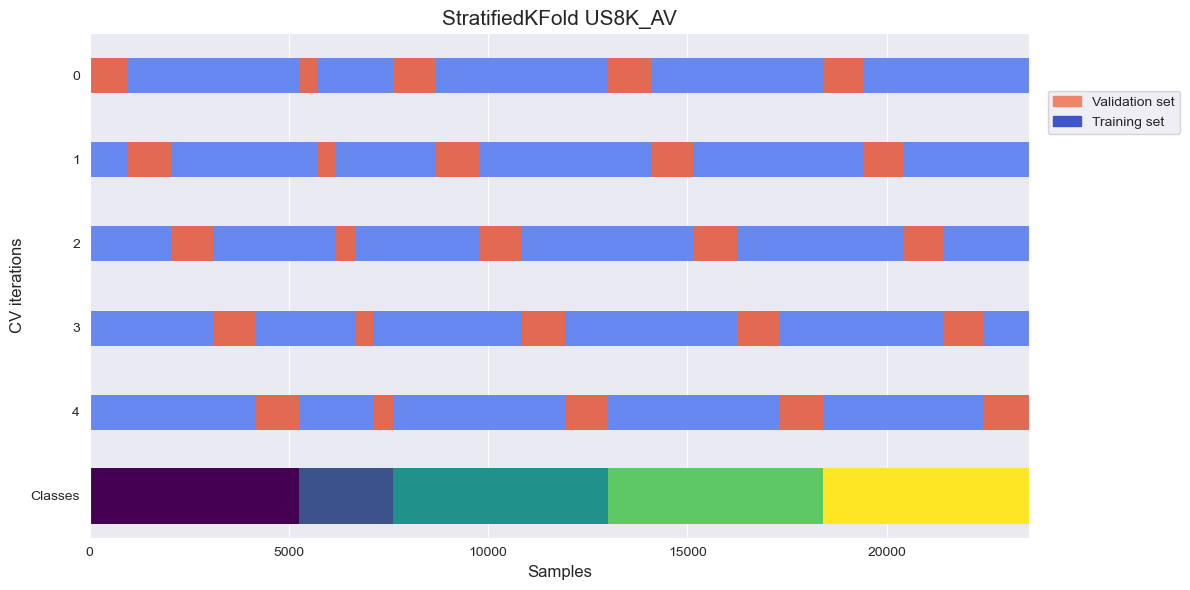

In [83]:
# Visualiza a divisão do treino / teste por meio do Stratified K Fold

print(sss)
print(skf)
print(kfd)
print()

visualizar_Kfold(nom_dataset, skf, X_norm, y, N_SPLITS)

## ML Modeling

In [84]:
del DB_from_pkl_VAL, DB_from_pkl_TRN

In [ ]:
# Separate 1 fold for validation and create a DB for the training / testing

opc = 0
while str(opc) not in '12':
    print()
    print("1-) Normalization")
    print("2-) Standardization")

    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0


    DB_from_pkl_VAL = DB_from_pkl[DB_from_pkl['Fold'] == fold].copy()
    DB_from_pkl_TRN = DB_from_pkl[DB_from_pkl['Fold'] != fold].copy()
    
    X      = DB_from_pkl_TRN.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
    y      = np.array(DB_from_pkl_TRN.Class_categorical.to_list())
    y_OHEV = np.array(DB_from_pkl_TRN.Class_OHEV.to_list())

    X_val      = DB_from_pkl_VAL.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
    y_val      = np.array(DB_from_pkl_VAL.Class_categorical.to_list())
    y_OHEV_val = np.array(DB_from_pkl_VAL.Class_OHEV.to_list())

    X_statistics = pd.DataFrame({'mean': X.mean(), 'std': X.std(), 'min': X.min(), 'max': X.max()})

    X_mean   = X_statistics.values[:, 0]
    X_std    = X_statistics.values[:, 1]
    X_min    = X_statistics.values[:, 2]
    X_max    = X_statistics.values[:, 3]
    
    # Normalization or standardization using values from the training set.
    if opc == 1:
        X_norm     = (X.values - X_min) / (X_max - X_min)
        X_val_norm = (X_val.values - X_min) / (X_max - X_min)
        norm_type  = '_norm'

    if opc == 2:
        X_norm     = (X.values - X_mean) / X_std
        X_val_norm = (X_val.values - X_mean) / X_std
        norm_type  = '_std'
        
    # Separated training and testing for hyperparameter cross-validation (10% testing).
    # Testing was not used in this notebook, but it was in the neural networks. In order to achieve a fair comparisson,
    # the same number of samples for training were considered in both notebooks.

    for idx_trn, idx_tst in sss.split(X_norm, y):
        X_train      = X_norm[idx_trn]
        X_test       = X_norm[idx_tst]
        y_train      = y[idx_trn]
        y_test       = y[idx_tst]
        y_train_OHEV = y_OHEV[idx_trn]
        y_test_OHEV  = y_OHEV[idx_tst]
        
        # Stores the indexes for future use
        idx_trn.tofile(os.path.join(path_models, '_idx_trn_' + nom_dataset + model_surname + '.csv'), sep=',')
        idx_tst.tofile(os.path.join(path_models, '_idx_tst_' + nom_dataset + model_surname + '.csv'), sep=',')


1-) Normalization
2-) Standardization


In [ ]:
print("\n==================================")
print("Training set\n")

print(f'X_train.........: {np.shape(X_train)}')
print(f'y_train.........: {np.shape(y_train)}')
print(f'y_train_OHEV....: {np.shape(y_train_OHEV)}')

print("\n==================================")
print("Testing set\n")

print(f'X_test..........: {np.shape(X_test)}')
print(f'y_test..........: {np.shape(y_test)}')
print(f'y_test_OHEV.....: {np.shape(y_test_OHEV)}')

print("\n==================================")
print("Validation set\n")

print(f'X_val_norm......: {np.shape(X_val_norm)}')
print(f'y_val...........: {np.shape(y_val)}')
print(f'y_OHEV_val......: {np.shape(y_OHEV_val)}')

In [ ]:
# Simple confusion matrix

def simple_conf_matrix(y_true, y_pred, nom_classes, clf, acc):
    
    picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

    conf_matrix = metrics.confusion_matrix(y_true, y_pred)
    title = nom_dataset + model_surname + norm_type + ' - Classifier ' + clf + ' - Validation accuracy: '+ str("{:0.2f} %".format(acc*100))

    plt.figure(figsize = (10,10))
    sns.heatmap(conf_matrix, 
                annot=True, 
                fmt='g', 
                cmap=cmap_cm, 
                annot_kws={"size": 8}, 
                xticklabels=nom_classes, 
                yticklabels=nom_classes)
    plt.title(title, fontsize = 12)
    plt.savefig(os.path.join(path_pic, picture_name))
    plt.show()

In [ ]:
# Plot the confusion matrix

def plot_confusion_matrix(cm, labels, title, cmap, normalize):

    picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

    if labels is not None:
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, fontsize=10, rotation=45)
        plt.yticks(tick_marks, labels, fontsize=10)
   
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize = 8)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize = 8)

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize=13)
    plt.colorbar(shrink=1)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)
    plt.savefig(os.path.join(path_pic, picture_name))
    plt.tight_layout()

## Classifiers

- **Gaussian Naive Bayes** (GaussianNB) is a probabilistic machine learning algorithm mainly used for classification tasks based on the Naive Bayes theorem and assumes that features are independent and follow a Gaussian (normal) distribution. GaussianNB is particularly suitable for datasets with continuous or real-valued features. It calculates the probabilities of different classes for a given set of input features and assigns the class with the highest probability as the predicted class. Despite its simplifying assumption of feature independence (which is often not met in practice), GaussianNB performs surprisingly well in various real-world applications, such as text classification and spam email detection, due to its simplicity and efficiency. 
***
- The **Support Vector Classifier** (SVC)  is a supervised machine learning algorithm that is primarily used for classification tasksby finding the optimal hyperplane that best separates different classes in the input data. It does this by identifying support vectors, which are the data points closest to the decision boundary. SVC aims to maximize the margin between these support vectors and the decision boundary, making it robust to outliers and capable of handling non-linear data through the use of kernel functions. The algorithm allows for multi-class classification and can be fine-tuned through various parameters like the choice of kernel, regularization strength (C), and kernel-specific parameters. 
***
- **Logistic Regression** is a supervised machine learning algorithm that's primarily employed for binary classification tasks, though it can be extended to handle multiclass classification as well. Despite its name, it's used for classification, not regression. Logistic Regression models the probability of an instance belonging to a particular class as a logistic function of the input features. It's particularly well-suited for linearly separable data, where it tries to find a linear decision boundary that separates the two classes. Regularization techniques like L1 and L2 can be applied to prevent overfitting, while logistic regression assumes a linear relationship between features and the log-odds of the target variable, it can be effective in many practical scenarios and serves as a fundamental building block for more complex models in machine learning.
***
- The **k-Nearest Neighbors** (KNN) algorithm is a simple supervised machine learning technique used primarily for classification and regression tasks. In KNN, a data point's class or value is determined by the majority class or average of its k-nearest neighbors in the feature space. It operates under the assumption that similar data points tend to have similar class labels or target values. The choice of the "k" parameter determines how many neighboring data points are considered when making predictions; a smaller k value leads to more localized decision boundaries, while a larger k value results in smoother, global boundaries. KNN is a non-parametric algorithm, meaning it doesn't make assumptions about the underlying data distribution but it can be computationally expensive for large datasets and may require proper feature scaling and distance metric selection to perform optimally.
***
- **Random Forest** is an ensemble machine learning algorithm used for both classification and regression tasks. It's based on the concept of decision trees, but it builds multiple trees and combines their predictions to improve accuracy and reduce overfitting. In a Random Forest, a random subset of the training data and a random subset of the features are used to grow each tree. This randomness helps create diverse trees that collectively make more robust predictions. During classification, the algorithm aggregates the votes from individual trees, and for regression, it averages their predictions. Random Forest is known for its high accuracy, ability to handle large datasets with many features, and resistance to overfitting. 

In [ ]:
# Plot the learning curve for the classifier

def plot_learning_curve(train_sizes, train_mean, train_std, test_mean, test_std, classifier):

    picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

    plt.figsize=(30, 30)
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title(nom_dataset + model_surname + norm_type + ' - Learning curve for ' + classifier)
    plt.xlabel('Training data size')
    plt.ylabel('Model accuracy')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(os.path.join(path_pic, picture_name))
    plt.show()

In [ ]:
NB_c = GaussianNB()
NB_c

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(estimator = NB_c, X = X_train, y = y_train,
                                                        cv = 5, train_sizes = np.linspace(0.1, 1.0, 10),
                                                        n_jobs = -1, verbose = 10)
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

In [ ]:
plot_learning_curve(train_sizes, 
                    train_mean, 
                    train_std, 
                    test_mean, 
                    test_std, 
                    'Naïve Bayes')

print(f"{train_sizes} samples were used to train the model\n")
print(f"The average train accuracy is....: {train_scores.mean()*100:.2f} % (+/-{train_std.mean()*100:.2f} %)")
print(f"The average test accuracy is.....: {test_scores.mean()*100:.2f} % (+/-{test_std.mean()*100:.2f} %)")

In [ ]:
NB_c.fit(X_train, y_train)

In [ ]:
NB_c_predict = NB_c.predict(X_val_norm)

In [ ]:
# Save the classifier to file in the current working directory

pkl_filename = "Model_GaussianNB" + norm_type + model_surname + ".pkl"
with open(os.path.join(path_models, pkl_filename), 'wb') as file:
    pickle.dump(NB_c, file)

In [ ]:
# Load the classifier from file

with open(os.path.join(path_models, pkl_filename), 'rb') as file:
    NB_c_saved = pickle.load(file)

In [ ]:
score_NB_c_saved = NB_c_saved.score(X_val_norm, y_val)
print("Test score (R2): {0:.2f} %".format(100 * score_NB_c_saved))
NB_c_saved_predict = NB_c_saved.predict(X_val_norm)

In [ ]:
t_srt = time.process_time_ns()

NB_c_saved_predict_val = NB_c_saved.predict(X_val_norm)

t_end = time.process_time_ns()
tempoProc = ((t_end - t_srt) / 1000000)
print("Processing time:", ('%.4f' % tempoProc).replace('.', ','), "ms")

In [ ]:
NBC_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                             NB_c_saved_predict_val, 
                                                             target_names = nom_classes, 
                                                             output_dict = False)
print(NBC_c_saved_val_class_report)

In [ ]:
NBC_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                             NB_c_saved_predict_val, 
                                                             target_names = nom_classes, 
                                                             output_dict = True)

NBC_c_saved_val_class_report_acc = NBC_c_saved_val_class_report['accuracy']
print(NBC_c_saved_val_class_report_acc)

In [ ]:
np.array_equal(NB_c_predict, NB_c_saved_predict)

In [ ]:
simple_conf_matrix(y_val, 
                   NB_c_saved_predict_val, 
                   nom_classes,
                   'Naïve Bayes',
                   NBC_c_saved_val_class_report_acc)

In [ ]:
def get_random_sample(array1, array2):
    # Check if both arrays have the same length
    if len(array1) != len(array2):
        raise ValueError("Arrays must have the same length")

    # Select a random index
    random_index = random.randint(0, len(array1) - 1)
    print(random_index)

    # Get the sample from the first array and the associated element from the second array
    sample = array1[random_index]
    associated_element = array2[random_index]

    # Return the result as a tuple
    return (sample, associated_element, random_index)

In [ ]:
random_sample = get_random_sample(y_val, X_val_norm)

In [ ]:
def plot_pred_sample(model, data_label, data, nom_classes):
    
    random_sample = get_random_sample(data_label, data)
    
    print(random_sample[0])
    predict_sample = model.predict([random_sample[1]])[0]

    predict_sample_proba = model.predict_proba([random_sample[1]])
    print(predict_sample)
    
    if random_sample[0] == predict_sample:
        predict_col = 'g'
    else:
        predict_col = 'r'

    # Plotting
    plt.figure(figsize = (16,6))
    plt.bar(nom_classes, predict_sample_proba[0], color = predict_col, alpha = 0.5)
    plt.xlabel('Classes')
    plt.xticks(rotation=90)
    plt.ylabel('Probabilities')
    plt.title(f'Prediction for sample: {random_sample[0]}', fontsize = 14)
    plt.show()
    return random_sample[2]

In [ ]:
random_index = plot_pred_sample(NB_c_saved, y_val, X_val_norm, nom_classes)

In [ ]:
print(y_val[random_index])
print(NB_c_saved.predict([X_val_norm[random_index]])[0])

In [ ]:
# Testing hyperparameters for SVC classifier - After several test, the hyperparameters were set

#SVC_hp = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 
#          'degree': [9, 15, 20],
#          'C':[0.010, 0.030, 0.1, 0.2, 0.5], 
#          'probability': [True, False],
#          'random_state': [SEED]}

#grid_SVC = GridSearchCV(SVC(), SVC_hp, refit = True, verbose=3)

#grid_SVC.fit(X_train, y_train)

#print(" Results from Grid Search in the SVC classifier " )
#print("\n The best estimator across ALL searched params....:\n",grid_SVC.best_estimator_)
#print("\n The best score across ALL searched params........:\n",grid_SVC.best_score_)
#print("\n The best parameters across ALL searched params...:\n",grid_SVC.best_params_)

In [ ]:
#grid_SVC.best_params_

In [ ]:
# degree = degree of the polynomial kernel function (‘poly’). Must be non-negative. Ignored by all other kernels.

SVC_c = SVC(kernel       = 'linear',
            degree       = 9,  
            C            = 0.5, 
            probability  = True, 
            random_state = SEED,
            verbose      = True)
SVC_c

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(estimator = SVC_c, X = X_train, y = y_train,
                                                        cv = 5, train_sizes = np.linspace(0.2, 1.0, 10),
                                                        n_jobs = -1, verbose = 10)
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

In [ ]:
plot_learning_curve(train_sizes, 
                    train_mean, 
                    train_std, 
                    test_mean, 
                    test_std, 
                    'SVC')

print(f"{train_sizes} samples were used to train the model\n")
print(f"The average train accuracy is....: {train_scores.mean()*100:.2f} % (+/-{train_std.mean()*100:.2f} %)")
print(f"The average test accuracy is.....: {test_scores.mean()*100:.2f} % (+/-{test_std.mean()*100:.2f} %)")

In [ ]:
SVC_c.fit(X_train, y_train)

In [ ]:
SVC_c_predict = SVC_c.predict(X_val_norm)

In [ ]:
# Save the classifier to file in the current working directory

pkl_filename = "Model_SVC" + norm_type + model_surname + ".pkl"
with open(os.path.join(path_models, pkl_filename), 'wb') as file:
    pickle.dump(SVC_c, file)

In [ ]:
# Load the classifier from file

with open(os.path.join(path_models, pkl_filename), 'rb') as file:
    SVC_c_saved = pickle.load(file)

In [ ]:
score_SVC_c_saved = SVC_c_saved.score(X_val_norm, y_val)
print("Test score (R2): {0:.2f} %".format(100 * score_SVC_c_saved))
SVC_c_saved_predict = SVC_c_saved.predict(X_val_norm)

In [ ]:
t_srt = time.process_time_ns()

SVC_c_saved_predict_val = SVC_c_saved.predict(X_val_norm)
2
t_end = time.process_time_ns()
tempoProc = ((t_end - t_srt) / 1000000)
print("Processing time:", ('%.4f' % tempoProc).replace('.', ','), "ms")

In [ ]:
SVC_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                             SVC_c_saved_predict_val, 
                                                             target_names = nom_classes, 
                                                             output_dict = False)
print(SVC_c_saved_val_class_report)

In [ ]:
SVC_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                             SVC_c_saved_predict_val, 
                                                             target_names = nom_classes, 
                                                             output_dict = True)
SVC_c_saved_val_class_report_acc = SVC_c_saved_val_class_report['accuracy']
SVC_c_saved_val_class_report_acc

In [ ]:
np.array_equal(SVC_c_predict, SVC_c_saved_predict)

In [ ]:
simple_conf_matrix(y_val, 
                   SVC_c_saved_predict_val, 
                   nom_classes,
                   'SVC',
                   SVC_c_saved_val_class_report_acc)

In [ ]:
random_index = plot_pred_sample(SVC_c_saved, y_val, X_val_norm, nom_classes)

In [ ]:
print(random_index)
print(y_val[random_index])
print(SVC_c_saved.predict([X_val_norm[random_index]])[0])

In [ ]:
# Testing hyperparameters for Logistic Regression classifier - After several test, the hyperparameters were set

#LogisticR_hp = {'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], 
#                'penalty': ['l1', 'l2', 'elasticnet', None],
#                'max_iter':[100, 150, 200, 500],
#                'C':[0.010, 0.030, 0.1, 0.2, 0.5]}

#grid_LogisticR = GridSearchCV(LogisticRegression(), LogisticR_hp, refit = True, verbose=3)

#grid_LogisticR.fit(X_train, y_train)

#print(" Results from Grid Search in the Logistic Regression classifier " )
#print("\n The best estimator across ALL searched params....:\n",grid_LogisticR.best_estimator_)
#print("\n The best score across ALL searched params........:\n",grid_LogisticR.best_score_)
#print("\n The best parameters across ALL searched params...:\n",grid_LogisticR.best_params_)

In [ ]:
#grid_LogisticR.best_params_

In [ ]:
LogisticR_c = LogisticRegression(solver    = 'saga', 
                                 C         = 0.5, 
                                 max_iter  = 500,
                                 verbose   = 10,
                                 n_jobs    = -1)
LogisticR_c

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(estimator = LogisticR_c, X = X_train, y = y_train,
                                                        cv = 5, train_sizes = np.linspace(0.2, 1.0, 10),
                                                        n_jobs = -1, verbose = 10)
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

In [ ]:
plot_learning_curve(train_sizes, 
                    train_mean, 
                    train_std, 
                    test_mean, 
                    test_std, 
                    'Logistic regression')

print(f"{train_sizes} samples were used to train the model\n")
print(f"The average train accuracy is....: {train_scores.mean()*100:.2f} % (+/-{train_std.mean()*100:.2f} %)")
print(f"The average test accuracy is.....: {test_scores.mean()*100:.2f} % (+/-{test_std.mean()*100:.2f} %)")

In [ ]:
LogisticR_c.fit(X_train, y_train)

In [ ]:
LogisticR_c_predict = LogisticR_c.predict(X_val_norm)

In [ ]:
# Save the classifier to file in the current working directory

pkl_filename = "Model_LogisticR" + norm_type + model_surname + ".pkl"
with open(os.path.join(path_models, pkl_filename), 'wb') as file:
    pickle.dump(LogisticR_c, file)

In [ ]:
# Load the classifier from file

with open(os.path.join(path_models, pkl_filename), 'rb') as file:
    LogisticR_c_saved = pickle.load(file)

In [ ]:
score_LogisticR_c_saved = LogisticR_c_saved.score(X_val_norm, y_val)
print("Test score (R2): {0:.2f} %".format(100 * score_LogisticR_c_saved))
LogisticR_c_saved_predict = LogisticR_c_saved.predict(X_val_norm)

In [ ]:
t_srt = time.process_time_ns()

LogisticR_c_saved_predict_val = LogisticR_c_saved.predict(X_val_norm)

t_end = time.process_time_ns()
tempoProc = ((t_end - t_srt) / 1000000)
print("Processing time:", ('%.4f' % tempoProc).replace('.', ','), "ms")

In [ ]:
LogisticR_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                                   LogisticR_c_saved_predict_val, 
                                                                   target_names = nom_classes, 
                                                                   output_dict = False)
print(LogisticR_c_saved_val_class_report)

In [ ]:
LogisticR_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                                   LogisticR_c_saved_predict_val, 
                                                                   target_names = nom_classes, 
                                                                   output_dict = True)
LogisticR_c_saved_val_class_report_acc = LogisticR_c_saved_val_class_report['accuracy']
LogisticR_c_saved_val_class_report_acc

In [ ]:
np.array_equal(LogisticR_c_predict, LogisticR_c_saved_predict)

In [ ]:
simple_conf_matrix(y_val, 
                   LogisticR_c_saved_predict_val, 
                   nom_classes,
                   'Logistic regression',
                   LogisticR_c_saved_val_class_report_acc)

In [ ]:
random_index = plot_pred_sample(LogisticR_c_saved, y_val, X_val_norm, nom_classes)

In [ ]:
print(y_val[random_index])
print(LogisticR_c_saved.predict([X_val_norm[random_index]])[0])

In [ ]:
# Testing hyperparameters for KNN classifier - After several test, the hyperparameters were set

#KNN_hp = {'n_neighbors':[3, 5, 8, 12], 
#          'metric': ['mahalanobis', 'euclidean', 'minkowski'],
#          'p':[1, 2], 
#          'leaf_size': [20, 40, 80]}

#grid_KNN = GridSearchCV(KNeighborsClassifier(), KNN_hp, refit = True, verbose=3)

#grid_KNN.fit(X_train, y_train)

#print(" Results from Grid Search in the SVC classifier " )
#print("\n The best estimator across ALL searched params....:\n",grid_KNN.best_estimator_)
#print("\n The best score across ALL searched params........:\n",grid_KNN.best_score_)
#print("\n The best parameters across ALL searched params...:\n",grid_KNN.best_params_)

In [ ]:
#grid_KNN.best_params_

In [ ]:
KNN_c = KNeighborsClassifier(n_neighbors = 3,
                             metric      = 'minkowski',
                             p           = 2,
                             leaf_size   = 20,
                             n_jobs      = -1)
KNN_c

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(estimator = KNN_c, X = X_train, y = y_train,
                                                        cv = 5, train_sizes = np.linspace(0.1, 1.0, 10),
                                                        n_jobs = -1, verbose = 10)
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

In [ ]:
plot_learning_curve(train_sizes, 
                    train_mean, 
                    train_std, 
                    test_mean, 
                    test_std, 
                    'KNN')

print(f"{train_sizes} samples were used to train the model\n")
print(f"The average train accuracy is....: {train_scores.mean()*100:.2f} % (+/-{train_std.mean()*100:.2f} %)")
print(f"The average test accuracy is.....: {test_scores.mean()*100:.2f} % (+/-{test_std.mean()*100:.2f} %)")

In [ ]:
KNN_c.fit(X_train, y_train)

In [ ]:
KNN_c_predict = KNN_c.predict(X_val_norm)

In [ ]:
# Save the classifier to file in the current working directory

pkl_filename = "Model_KNN" + norm_type + model_surname + ".pkl"
with open(os.path.join(path_models, pkl_filename), 'wb') as file:
    pickle.dump(KNN_c, file)

In [ ]:
# Load the classifier from file

with open(os.path.join(path_models, pkl_filename), 'rb') as file:
    KNN_c_saved = pickle.load(file)

In [ ]:
score_KNN_c_saved = KNN_c_saved.score(X_val_norm, y_val)
print("Test score (R2): {0:.2f} %".format(100 * score_KNN_c_saved))
KNN_c_saved_predict = KNN_c_saved.predict(X_val_norm)

In [ ]:
t_srt = time.process_time_ns()

KNN_c_saved_predict_val = KNN_c_saved.predict(X_val_norm)

t_end = time.process_time_ns()
tempoProc = ((t_end - t_srt) / 1000000)
print("Processing time:", ('%.4f' % tempoProc).replace('.', ','), "ms")

In [ ]:
KNN_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                             KNN_c_saved_predict_val, 
                                                             target_names = nom_classes, 
                                                             output_dict = False)
print(KNN_c_saved_val_class_report)

In [ ]:
KNN_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                             KNN_c_saved_predict_val, 
                                                             target_names = nom_classes, 
                                                             output_dict = True)
KNN_c_saved_val_class_report_acc = KNN_c_saved_val_class_report['accuracy']
KNN_c_saved_val_class_report_acc

In [ ]:
np.array_equal(KNN_c_predict, KNN_c_saved_predict)

In [ ]:
simple_conf_matrix(y_val, 
                   KNN_c_saved_predict_val, 
                   nom_classes,
                   'KNN',
                   KNN_c_saved_val_class_report_acc)

In [ ]:
random_index = plot_pred_sample(KNN_c_saved, y_val, X_val_norm, nom_classes)

In [ ]:
print(y_val[random_index])
print(KNN_c_saved.predict([X_val_norm[random_index]])[0])

In [ ]:
# Testing hyperparameters for random forest classifier (ensemble method) - After several test, the hyperparameters were set

#forest_hp = {'n_estimators':[10, 25, 50, 100, 200, 500], 
#             'criterion': ['gini', 'entropy', 'log_loss'],
#             'bootstrap':[True, False]}

#grid_forest = GridSearchCV(RandomForestClassifier(), forest_hp, refit = True, verbose=3)

#grid_forest.fit(X_train, y_train)

#print(" Results from Grid Search in the SVC classifier " )
#print("\n The best estimator across ALL searched params....:\n",grid_forest.best_estimator_)
#print("\n The best score across ALL searched params........:\n",grid_forest.best_score_)
#print("\n The best parameters across ALL searched params...:\n",grid_forest.best_params_)

In [ ]:
#grid_forest.best_params_

In [ ]:
# Change to verbose = 0 when running the US8K_AV to avoid showing the information during the evaluation flow
forest_c = RandomForestClassifier(criterion    = 'gini',
                                  n_estimators = 500,
                                  bootstrap    = True,
                                  n_jobs       = -1,
                                  verbose      = 0)
forest_c

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(estimator = forest_c, X = X_train, y = y_train,
                                                        cv = 5, train_sizes = np.linspace(0.1, 1.0, 10),
                                                        n_jobs = -1, verbose = 10)
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

In [ ]:
plot_learning_curve(train_sizes, 
                    train_mean, 
                    train_std, 
                    test_mean, 
                    test_std, 
                    'Random forest')

print(f"{train_sizes} samples were used to train the model\n")
print(f"The average train accuracy is....: {train_scores.mean()*100:.2f} % (+/-{train_std.mean()*100:.2f} %)")
print(f"The average test accuracy is.....: {test_scores.mean()*100:.2f} % (+/-{test_std.mean()*100:.2f} %)")

In [ ]:
forest_c.fit(X_train, y_train)

In [ ]:
forest_c_predict = forest_c.predict(X_val_norm)

In [ ]:
# Plot the feature importances of the random forest classifier

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'
plt.figure(num=None, figsize=(20,8), facecolor='w', edgecolor='k')
feat_importances = pd.Series(forest_c.feature_importances_, index= X.columns)
temp_feature     = feat_importances.nlargest(375).reset_index()
rff = feat_importances.nlargest(375).plot(kind='bar')
rff.set_xticklabels(temp_feature['index'], fontsize=8)
plt.title(nom_dataset + model_surname + ' - The impurity-based feature importances of the random forest classifier', fontsize = 14)
plt.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))
plt.show()

In [ ]:
feat_importances.nlargest(375).sum()

In [ ]:
# Save the classifier to file in the current working directory

pkl_filename = "Model_Forest" + norm_type + model_surname + ".pkl"
with open(os.path.join(path_models, pkl_filename), 'wb') as file:
    pickle.dump(forest_c, file)

In [ ]:
# Load the classifier from file

with open(os.path.join(path_models, pkl_filename), 'rb') as file:
    forest_c_saved = pickle.load(file)

In [ ]:
score_forest_c_saved = forest_c_saved.score(X_val_norm, y_val)
print("Test score (R2): {0:.2f} %".format(100 * score_forest_c_saved))
forest_c_saved_predict = forest_c_saved.predict(X_val_norm)

In [ ]:
t_srt = time.process_time_ns()

forest_c_saved_predict_val = forest_c_saved.predict(X_val_norm)

t_end = time.process_time_ns()
tempoProc = ((t_end - t_srt) / 1000000)
print("Processing time:", ('%.4f' % tempoProc).replace('.', ','), "ms")

In [ ]:
forest_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                                forest_c_saved_predict_val, 
                                                                target_names = nom_classes, 
                                                                output_dict = False)
print(forest_c_saved_val_class_report)

In [ ]:
forest_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                                forest_c_saved_predict_val, 
                                                                target_names = nom_classes, 
                                                                output_dict = True)
forest_c_saved_val_class_report_acc = forest_c_saved_val_class_report['accuracy']
forest_c_saved_val_class_report_acc

In [ ]:
np.array_equal(forest_c_predict, forest_c_saved_predict)

In [ ]:
simple_conf_matrix(y_val, 
                   forest_c_saved_predict_val, 
                   nom_classes,
                   'Random forest',
                   forest_c_saved_val_class_report_acc)

In [ ]:
random_index = plot_pred_sample(forest_c_saved, y_val, X_val_norm, nom_classes)

In [ ]:
print(y_val[random_index])
print(forest_c_saved.predict([X_val_norm[random_index]])[0])

### Evaluating a voting classifier for the ML algorithms

In [ ]:
labels = ['Naïves Bayes', 'SVC', 'Logistic regression', 'KNN']

In [ ]:
for clf, label in zip([NB_c, SVC_c, LogisticR_c, KNN_c], labels):
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy', n_jobs = -1, verbose = 10)
    print(label, " Accuracy: {0:.2f} % (+/- {1:.2f} %)".format(100*scores.mean(), 100*scores.std()))

In [ ]:
voting_clf_hard = VotingClassifier(estimators = [(labels[0], NB_c),
                                                 (labels[1], SVC_c),
                                                 (labels[2], LogisticR_c),
                                                 (labels[3], KNN_c)],
                                   voting = 'hard',
                                   n_jobs = -1,
                                   verbose = True)

In [ ]:
voting_clf_soft = VotingClassifier(estimators = [(labels[0], NB_c),
                                                 (labels[1], SVC_c),
                                                 (labels[2], LogisticR_c),
                                                 (labels[3], KNN_c)],
                                   voting = 'soft',
                                   n_jobs = -1,
                                   verbose = True)

In [ ]:
# Save the classifier to file in the current working directory

pkl_filename_hard = "Model_voting_hard" + norm_type + model_surname + ".pkl"
with open(os.path.join(path_models, pkl_filename_hard), 'wb') as file:
    pickle.dump(voting_clf_hard, file)

In [ ]:
# Save the classifier to file in the current working directory

pkl_filename_soft = "Model_voting_soft" + norm_type + model_surname + ".pkl"
with open(os.path.join(path_models, pkl_filename_soft), 'wb') as file:
    pickle.dump(voting_clf_soft, file)

In [ ]:
labels_new = ['Naïves Bayes', 'SVC', 'Logistic regression', 'KNN', 'Random forest', 'Voting hard', 'Voting soft']

In [ ]:
# Load the classifier from file

with open(os.path.join(path_models, pkl_filename_hard), 'rb') as file:
    voting_clf_hard_saved = pickle.load(file)

In [ ]:
# Load the classifier from file

with open(os.path.join(path_models, pkl_filename_soft), 'rb') as file:
    voting_clf_soft_saved = pickle.load(file)

In [ ]:
for clf, label in zip([NB_c, SVC_c, LogisticR_c, KNN_c, forest_c, voting_clf_hard, voting_clf_soft], labels_new):
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy', n_jobs = -1, verbose = 10)
    print(label, " Accuracy: {0:.2f} % (+/- {1:.2f} %)".format(100*scores.mean(), 100*scores.std()))

In [ ]:
for clf, label in zip([NB_c, SVC_c, LogisticR_c, KNN_c, forest_c, voting_clf_hard_saved, voting_clf_soft_saved], labels_new):
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy', n_jobs = -1, verbose = 10)
    print(label, "Accuracy: {0:.2f} % (+/- {1:.2f} %)".format(100*scores.mean(), 100*scores.std()))

In [ ]:
voting_clf_hard_saved.fit(X_train, y_train)

In [ ]:
t_srt = time.process_time_ns()

votingHard_c_saved_predict_val = voting_clf_hard_saved.predict(X_val_norm)

t_end = time.process_time_ns()
tempoProc = ((t_end - t_srt) / 1000000)
print("Processing time:", ('%.4f' % tempoProc).replace('.', ','), "ms")

In [ ]:
votingHard_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                                    votingHard_c_saved_predict_val, 
                                                                    target_names = nom_classes, 
                                                                    output_dict = False)
print(votingHard_c_saved_val_class_report)

In [ ]:
votingHard_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                                    votingHard_c_saved_predict_val, 
                                                                    target_names = nom_classes, 
                                                                    output_dict = True)
votingHard_c_saved_val_class_report_acc = votingHard_c_saved_val_class_report['accuracy']
votingHard_c_saved_val_class_report_acc

In [ ]:
simple_conf_matrix(y_val, 
                   votingHard_c_saved_predict_val, 
                   nom_classes,
                   'Voting hard',
                   votingHard_c_saved_val_class_report_acc)

In [ ]:
voting_clf_soft_saved.fit(X_train, y_train)

In [ ]:
t_srt = time.process_time_ns()

votingSoft_c_saved_predict_val = voting_clf_soft_saved.predict(X_val_norm)

t_end = time.process_time_ns()
tempoProc = ((t_end - t_srt) / 1000000)
print("Processing time:", ('%.4f' % tempoProc).replace('.', ','), "ms")

In [ ]:
votingSoft_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                                    votingSoft_c_saved_predict_val, 
                                                                    target_names = nom_classes, 
                                                                    output_dict = False)
print(votingSoft_c_saved_val_class_report)

In [ ]:
votingSoft_c_saved_val_class_report = metrics.classification_report(y_val, 
                                                                    votingSoft_c_saved_predict_val, 
                                                                    target_names = nom_classes, 
                                                                    output_dict = True)
votingSoft_c_saved_val_class_report_acc = votingSoft_c_saved_val_class_report['accuracy']
votingSoft_c_saved_val_class_report_acc

In [ ]:
simple_conf_matrix(y_val, 
                   votingSoft_c_saved_predict_val, 
                   nom_classes,
                   'Voting soft',
                   votingSoft_c_saved_val_class_report_acc)

# End of notebook